# Exploratory Notebook

In [1]:
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
import sqlite3 as sql
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import ast

___

## Assessing Box Office Mojo Data

In [2]:
#Path to file to account for difference in partner's directory setup
bom_file = '../zippedData/bom.movie_gross.csv.gz'
#Load data into dataframe
bom_df = pd.read_csv(bom_file)

In [3]:
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [4]:
bom_df.keys()

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')

In [5]:
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [6]:
bom_df['year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

Looks like the data in this set is films released from 2010 - 2018

In [7]:
#Converting numeric foreign_gross values to floats, and all other values to NaN
bom_df['foreign_gross'] = pd.to_numeric(bom_df['foreign_gross'], errors='coerce')

#Finding the maximum and minimum values of the domestic & foreign columns
print(f"Max foreign gross: {bom_df['foreign_gross'].max()}")
print(f"Min foreign gross: {bom_df['foreign_gross'].min()}")
print()
print(f"Max domestic gross: {bom_df['domestic_gross'].max()}")
print(f"Min domestic gross: {bom_df['domestic_gross'].min()}")

Max foreign gross: 960500000.0
Min foreign gross: 600.0

Max domestic gross: 936700000.0
Min domestic gross: 100.0


In [8]:
bom_df['studio'].unique()

array(['BV', 'WB', 'P/DW', 'Sum.', 'Par.', 'Uni.', 'Fox', 'Wein.', 'Sony',
       'FoxS', 'SGem', 'WB (NL)', 'LGF', 'MBox', 'CL', 'W/Dim.', 'CBS',
       'Focus', 'MGM', 'Over.', 'Mira.', 'IFC', 'CJ', 'NM', 'SPC', 'ParV',
       'Gold.', 'JS', 'RAtt.', 'Magn.', 'Free', '3D', 'UTV', 'Rela.',
       'Zeit.', 'Anch.', 'PDA', 'Lorb.', 'App.', 'Drft.', 'Osci.', 'IW',
       'Rog.', nan, 'Eros', 'Relbig.', 'Viv.', 'Hann.', 'Strand', 'NGE',
       'Scre.', 'Kino', 'Abr.', 'CZ', 'ATO', 'First', 'GK', 'FInd.',
       'NFC', 'TFC', 'Pala.', 'Imag.', 'NAV', 'Arth.', 'CLS', 'Mont.',
       'Olive', 'CGld', 'FOAK', 'IVP', 'Yash', 'ICir', 'FM', 'Vita.',
       'WOW', 'Truly', 'Indic.', 'FD', 'Vari.', 'TriS', 'ORF', 'IM',
       'Elev.', 'Cohen', 'NeoC', 'Jan.', 'MNE', 'Trib.', 'Rocket',
       'OMNI/FSR', 'KKM', 'Argo.', 'SMod', 'Libre', 'FRun', 'WHE', 'P4',
       'KC', 'SD', 'AM', 'MPFT', 'Icar.', 'AGF', 'A23', 'Da.', 'NYer',
       'Rialto', 'DF', 'KL', 'ALP', 'LG/S', 'WGUSA', 'MPI', 'RTWC', 'FIP

In [9]:
bom_df['studio'].value_counts()

studio
IFC           166
Uni.          147
WB            140
Fox           136
Magn.         136
             ... 
E1              1
PI              1
ELS             1
PalT            1
Synergetic      1
Name: count, Length: 257, dtype: int64

In [10]:
#Locate the highest and lowest grossing films indexes
max_dom_index = bom_df['domestic_gross'].idxmax()
min_dom_index = bom_df['domestic_gross'].idxmin()
max_intl_index = bom_df['foreign_gross'].idxmax()
min_intl_index = bom_df['foreign_gross'].idxmin()

print("Studio with Maximum Domestic Gross:", bom_df.loc[max_dom_index, 'studio'])
print("Studio with Minimum Domestic Gross:", bom_df.loc[min_dom_index, 'studio'])
print()
print("Studio with Maximum Foreign Gross:", bom_df.loc[max_intl_index, 'studio'])
print("Studio with Minimum Foreign Gross:", bom_df.loc[min_intl_index, 'studio'])

Studio with Maximum Domestic Gross: BV
Studio with Minimum Domestic Gross: Magn.

Studio with Maximum Foreign Gross: WB
Studio with Minimum Foreign Gross: Fox


We know we have a lot of information on Magn, Fox, and WB. Let's check the value count for BV.

In [11]:
print((bom_df['studio'] == 'BV').sum())

106


In [12]:
#Cleaning the Magn cell value
bom_df['studio'] = bom_df['studio'].str.rstrip('.').str.strip()

In [13]:
#Create variables for studios with highest and lowest grossing films
bv_films = bom_df[bom_df['studio'] == 'BV']
magn_films = bom_df[bom_df['studio'] == 'Magn']
wb_films = bom_df[bom_df['studio'] == 'WB']
fox_films = bom_df[bom_df['studio'] == 'Fox']

#Find their unique value counts
bv_films.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010
7,Tangled,BV,200800000.0,391000000.0,2010
13,Tron Legacy,BV,172100000.0,228000000.0,2010
15,Prince of Persia: The Sands of Time,BV,90800000.0,245600000.0,2010


### Keeping Box Office Mojo Data
This data has a ton of useful information. We'll briefly explore the other datasets, then return to this dataframe for further cleaning and analysis!

___

## Assessing Rotten Tomatoes Data

In [14]:
#Path to file to account for difference in partner's directory setup
rt_movieinfo_file = '../zippedData/rt.movie_info.tsv.gz'
#Load data into dataframe
rt_movieinfo_df = pd.read_csv(rt_movieinfo_file, delimiter ='\t')
rt_movieinfo_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [15]:
rt_movieinfo_df.keys()

Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio'],
      dtype='object')

In [16]:
rt_movieinfo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [17]:
#Path to file to account for difference in partner's directory setup
rt_reviews_file = '../zippedData/rt.reviews.tsv.gz'
#Load data into dataframe
rt_reviews_df = pd.read_csv(rt_reviews_file, delimiter='\t', encoding='latin1')

In [18]:
rt_reviews_df.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [19]:
rt_reviews_df.keys()

Index(['id', 'review', 'rating', 'fresh', 'critic', 'top_critic', 'publisher',
       'date'],
      dtype='object')

In [20]:
rt_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


### Dropping Rotten Tomatoes Dataset from Analysis
Reviews are so subjective, and largely out of filmmaker/studio control. They are not a good metric by which to plan strategy for profit.

Furthermore, most of the values in 'box_office' for Rotten Tomatoes data is missing. Since we aren't given film titles, to cross reference with other dataframes, further exploring the RottenTomatoes data is not going to be the best use of our time.

___

## Assessing TheMovieDB Data

In [21]:
#Path to file to account for difference in partner's directory setup
tmdb_file = '../zippedData/tmdb.movies.csv.gz'
#Load data into dataframe
tmdb_df = pd.read_csv(tmdb_file)
tmdb_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [22]:
tmdb_df.keys()

Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')

In [23]:
tmdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


### Genre Ids
Genre Ids could be useful for filling in missing genre information in other datasets. Let's do a little further research. 

Here are the ids with their corresponding genres, according to TheMovieDb...

In [24]:
#Converting the genre_ids to numerical dtype

#Determining whether each cell is a list of strings, or a string that looks like a list
tmdb_df['genre_ids'].unique()

array(['[12, 14, 10751]', '[14, 12, 16, 10751]', '[12, 28, 878]', ...,
       '[18, 14, 27, 878, 10749, 53]', '[16, 27, 9648]',
       '[10751, 12, 28]'], dtype=object)

In [25]:
#Define function to convert cells to lists of integers
def str_to_int_list(genre_ids):
    try:
        int_list = ast.literal_eval(genre_ids)
        if isinstance(int_list, list):
            return [int(item) for item in int_list]
        else:
            return []
    except (SyntaxError, ValueError):
        return []

#Apply this function to the column
tmdb_df['genre_ids'] = tmdb_df['genre_ids'].apply(str_to_int_list)

In [26]:
tmdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [27]:
#Creating a dictionary that maps the ids to their genres
genre_mapping_dict = {
    28: 'Action',
    12: 'Adventure',
    16: 'Animation',
    35: 'Comedy',
    80: 'Crime',
    99: 'Documentary',
    18: 'Drama',
    10751: 'Family',
    14: 'Fantasy',
    36: 'History',
    27: 'Horror',
    10402: 'Music',
    9648: 'Mystery',
    10749: 'Romance',
    878: 'Science Fiction',
    10770: 'TV Movie',
    53: 'Thriller',
    10752: 'War',
    37: 'Western',
}

#Now define a function that maps the ids to their genres
def map_id_genre(genre_ids):
    return[genre_mapping_dict.get(id, 'Unknown') for id in genre_ids]

#Create a new column in the dataframe with the genre names
tmdb_df['genre_names'] = tmdb_df['genre_ids'].apply(map_id_genre)

In [28]:
tmdb_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,genre_names
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"[Adventure, Fantasy, Family]"
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"[Fantasy, Adventure, Animation, Family]"
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"[Adventure, Action, Science Fiction]"
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,"[Animation, Comedy, Family]"
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,"[Action, Science Fiction, Adventure]"


### Setting Aside TheMovieDB Data

This data is also not particularly useful to our examination of monetary profit. The quantitative metrics of a films "popularity" could prove to be useful down the line, so for now we'll keep this dataset on the backburner.

___

## Assessing The Numbers Data

In [29]:
#Path to file to account for difference in partner's directory setup
tn_budgets_file = '../zippedData/tn.movie_budgets.csv.gz'
#Load data into dataframe
tn_budgets_df = pd.read_csv(tn_budgets_file)
tn_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [30]:
tn_budgets_df.keys()

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')

In [31]:
tn_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


### Production Budget
Knowing a film's product budget would be incredibly useful. Then we can develop a metric of "net profit", comparing how much the film grossed after it's released compared to how much money was required to make the film. 

Let's convert all the cell values to integers, and see how many NaN values we actually have.

In [32]:
money_columns = ['production_budget', 'domestic_gross', 'worldwide_gross']

#Remove '$' signs from all cell values, before converting them to integers
for col in money_columns:
    tn_budgets_df[col] = tn_budgets_df[col].str.replace('$', '', regex=False)

### Cleaning cell values

When trying to convert the monetary columns into numeric datatypes, we've run into some issues.

Monetary values from other datasets do not contain commas. Lets remove commas as well to make it easier to cross reference between dataframes, and hopefully troubleshoot any formatting issues when converting between datatypes.

In [33]:
#Remove all commas
for col in money_columns:
    tn_budgets_df[col] = tn_budgets_df[col].str.replace(',','')

In [34]:
#Testing before modifying original column
prod_converted_values = pd.to_numeric(tn_budgets_df['production_budget'], errors='coerce')
prod_converted_values.head()

0    425000000
1    410600000
2    350000000
3    330600000
4    317000000
Name: production_budget, dtype: int64

In [35]:
prod_converted_values.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5782 entries, 0 to 5781
Series name: production_budget
Non-Null Count  Dtype
--------------  -----
5782 non-null   int64
dtypes: int64(1)
memory usage: 45.3 KB


In [36]:
dom_converted_values = pd.to_numeric(tn_budgets_df['domestic_gross'], errors='coerce')
dom_converted_values.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5782 entries, 0 to 5781
Series name: domestic_gross
Non-Null Count  Dtype
--------------  -----
5782 non-null   int64
dtypes: int64(1)
memory usage: 45.3 KB


In [37]:
intl_converted_values = pd.to_numeric(tn_budgets_df['worldwide_gross'], errors='coerce')
intl_converted_values.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5782 entries, 0 to 5781
Series name: worldwide_gross
Non-Null Count  Dtype
--------------  -----
5782 non-null   int64
dtypes: int64(1)
memory usage: 45.3 KB


In [38]:
#Converting all original columns to numeric data types
for col in money_columns:
    tn_budgets_df[col] = pd.to_numeric(tn_budgets_df[col], errors='coerce')

tn_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   int64 
 4   domestic_gross     5782 non-null   int64 
 5   worldwide_gross    5782 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 271.2+ KB


### DateTime, Isolating Year

In [39]:
tn_budgets_df['release_date'].value_counts()

release_date
Dec 31, 2014    24
Dec 31, 2015    23
Dec 31, 2010    15
Dec 31, 2008    14
Dec 31, 2009    13
                ..
Oct 21, 1977     1
Jun 23, 2009     1
Sep 26, 2017     1
Nov 14, 2007     1
Jul 13, 2005     1
Name: count, Length: 2418, dtype: int64

In [40]:
#Converting release_date to datetime values
tn_budgets_df['release_date'] = pd.to_datetime(tn_budgets_df['release_date'], format='%b %d, %Y')

#Creating new 'year' column with each films year
tn_budgets_df['year'] = tn_budgets_df['release_date'].dt.year

In [41]:
tn_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   year               5782 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(4), object(1)
memory usage: 293.7+ KB


In [42]:
tn_years = tn_budgets_df['year'].unique()
tn_years.sort()

tn_years

array([1915, 1916, 1920, 1925, 1927, 1929, 1930, 1931, 1933, 1934, 1935,
       1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int32)

### Drop outdated information
Our data includes films released from 1915-2020. Data from 1915 is certainly irrelevant. Let's drop everything prior to 2000, then look at our value counts to see if we narrow our search even further.

In [43]:
tn_budgets_filtered = tn_budgets_df[tn_budgets_df['year'] >= 2000]

In [44]:
tn_budgets_filtered['year'].value_counts().sort_index(ascending = False)

year
2020      3
2019     67
2018    143
2017    168
2016    219
2015    338
2014    255
2013    238
2012    235
2011    254
2010    274
2009    239
2008    264
2007    220
2006    260
2005    223
2004    206
2003    201
2002    210
2001    181
2000    189
Name: count, dtype: int64

For now, let's stick with films from the past 20 years. We can continue to filter as needed.

In [45]:
#Modifying original dataframe
tn_budgets_df = tn_budgets_df[tn_budgets_df['year'] >=2000]

### Keeping The Numbers Data
Similar to our Box Office Mojo dataset, this data also has a ton of useful information. We'll briefly explore the other datasets, then return to this dataframe for further cleaning and analysis!

___

# IMDB Data
The most important dataset we have is from imdb. Let's begin to parse through it.

Since we're using SQL, it might be helpful to have a visual reference of how our data is connected.

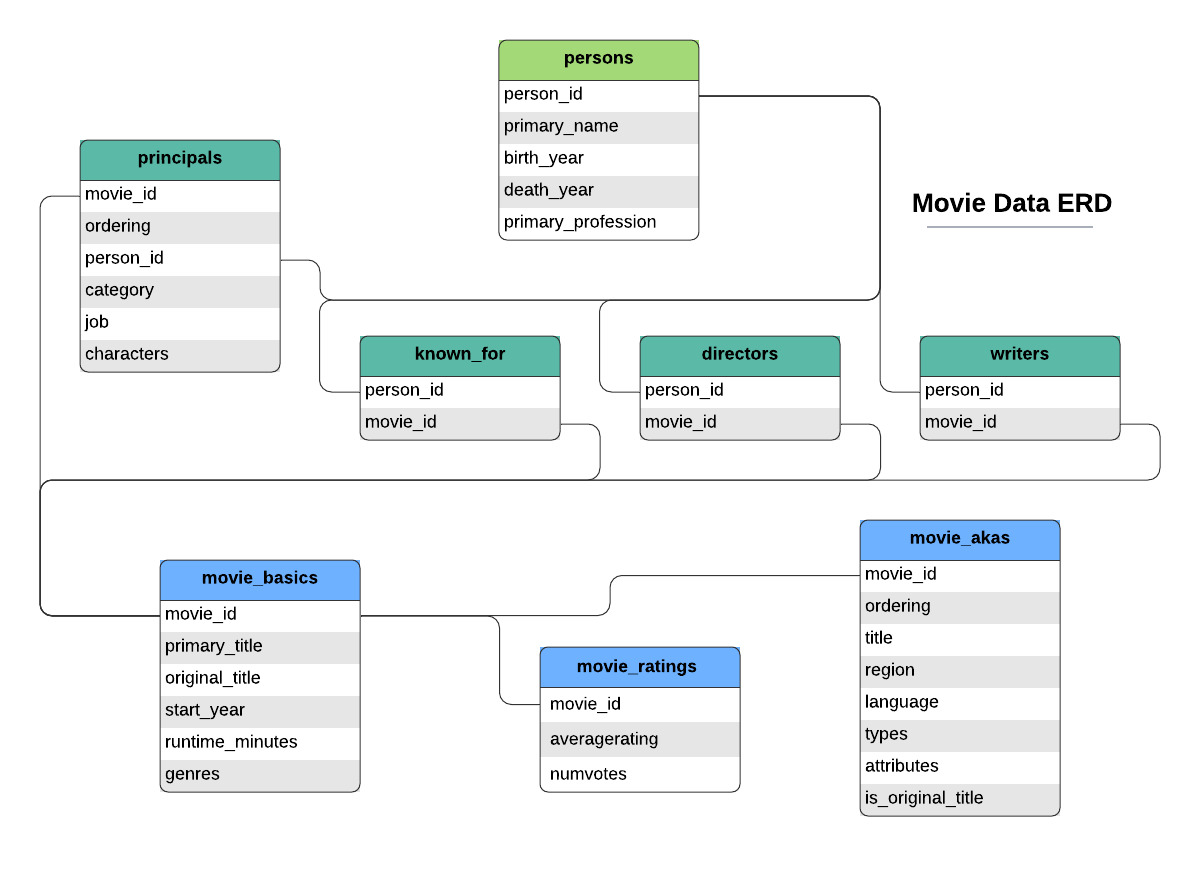

Our most relevant tables will be **movie_basics** and **movie_ratings**.

In [46]:
#Need to unzip the file
import zipfile
import os
zip_file = '../zippedData/im.db.zip'
extract_to = 'Data'
os.makedirs(extract_to, exist_ok=True)
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [47]:
#We'll be looking at a lot of tables, so let's create a report
def df_report(df):
    print(df.info())
    print('===========================================================\n')
    print(df.describe())
    print('===========================================================\n')
    print(df.head())

In [48]:
# Set up the sql connection to im.db
#Path to file to account for difference in partner's directory setup
imdb_file = 'Data/im.db'
conn = sql.connect(imdb_file)

In [49]:
# Have a look at the tables in the imdb
tables_df = pd.read_sql("""SELECT name FROM sqlite_master WHERE type = 'table';""", conn)
tables_df

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


___

## Movie Basics
Exploring the movie_basics table.

In [50]:
movie_basics_df = pd.read_sql(f"""
    SELECT *
    FROM
        movie_basics
    """, conn)

df_report(movie_basics_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB
None

          start_year  runtime_minutes
count  146144.000000    114405.000000
mean     2014.621798        86.187247
std         2.733583       166.360590
min      2010.000000         1.000000
25%      2012.000000        70.000000
50%      2015.000000        87.000000
75%      2017.000000        99.000000
max      2115.000000     51420.000000

    movie_id                    primary_title              original_title  \
0  tt0063540              

### Examining DateTime Values
There's a film with a 2115 start-date. Let's have a look at all other start-date values in the future.

In [51]:
# some with start dates that haven't occurred yet, lets have a look:
df_report(movie_basics_df.query('start_year > 2024'))

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 2949 to 96592
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         4 non-null      object 
 1   primary_title    4 non-null      object 
 2   original_title   4 non-null      object 
 3   start_year       4 non-null      int64  
 4   runtime_minutes  0 non-null      float64
 5   genres           4 non-null      object 
dtypes: float64(1), int64(1), object(4)
memory usage: 224.0+ bytes
None

       start_year  runtime_minutes
count     4.00000              0.0
mean   2048.25000              NaN
std      44.50749              NaN
min    2025.00000              NaN
25%    2025.75000              NaN
50%    2026.50000              NaN
75%    2049.00000              NaN
max    2115.00000              NaN

         movie_id            primary_title           original_title  \
2949   tt10300398  Untitled Star Wars Film  Untitled Star Wars Film   

#### Dropping Unreleased Films
There are only four films with start-dates in the future. Let's drop those.

In [52]:
# they were all movies yet to occur, lets get rid of them
movie_basics_df = movie_basics_df.query('start_year < 2025')
df_report(movie_basics_df)

<class 'pandas.core.frame.DataFrame'>
Index: 146140 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146140 non-null  object 
 1   primary_title    146140 non-null  object 
 2   original_title   146119 non-null  object 
 3   start_year       146140 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140732 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 7.8+ MB
None

          start_year  runtime_minutes
count  146140.000000    114405.000000
mean     2014.620877        86.187247
std         2.720489       166.360590
min      2010.000000         1.000000
25%      2012.000000        70.000000
50%      2015.000000        87.000000
75%      2017.000000        99.000000
max      2024.000000     51420.000000

    movie_id                    primary_title              original_title  \
0  tt0063540                   

### Runtime Values
##### Exploring Outliers

<Axes: ylabel='runtime_minutes'>

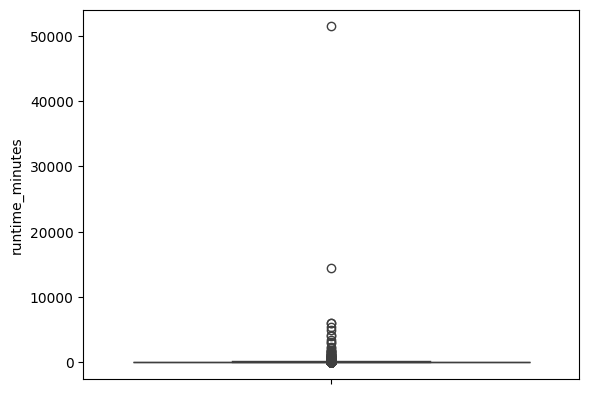

In [53]:
sns.boxplot(movie_basics_df.runtime_minutes)

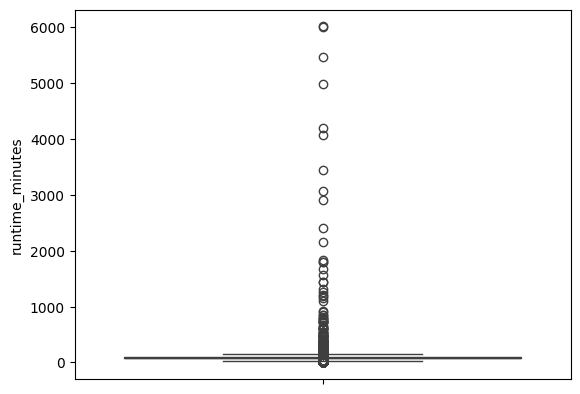

In [54]:
#Same boxplot without extreme outliers
sns.boxplot(movie_basics_df.query('runtime_minutes < 10000').runtime_minutes);

##### Dropping Too Long Films
Let's assume stakeholders are not interesting in very long (>4hr) films.

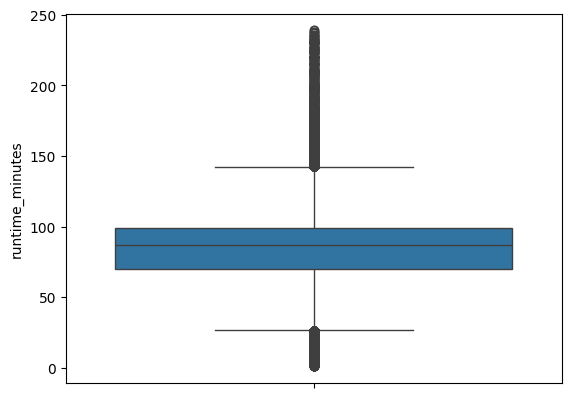

In [55]:
sns.boxplot(movie_basics_df.query('runtime_minutes < 240').runtime_minutes);

This doesn't look too far from normal distribution now, lets go ahead and remove movies over 4hr

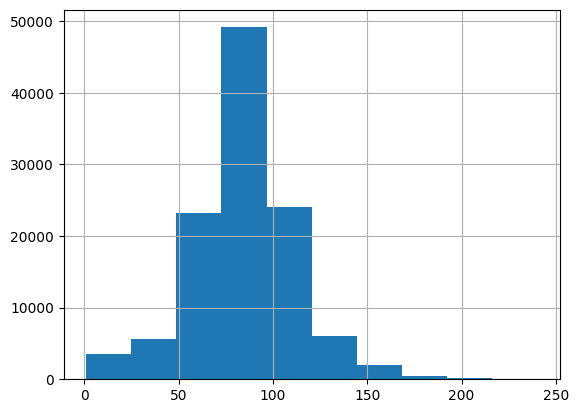

In [56]:
movie_basics_df = movie_basics_df.query('runtime_minutes <= 240')
movie_basics_df.runtime_minutes.hist();

#### Short Films
Let's look at the distribution of short films. Distinguishing the difference between short films and full-length, or "feature", films will eventually be crucial for our analysis.

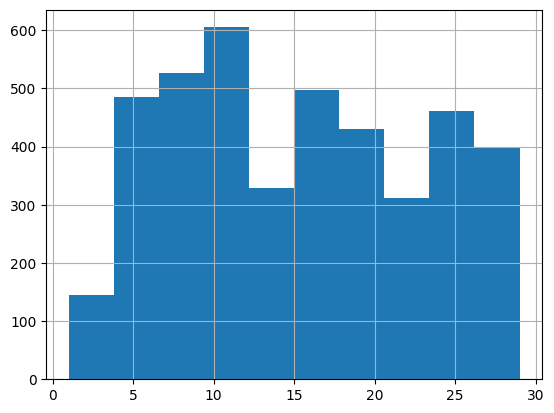

In [57]:
movie_basics_df.query('runtime_minutes < 30').runtime_minutes.hist();

There are no extreme outliers within the short films category. We'll leave them be for now.

### Null Values
Let's look at null values.

In [58]:
df_report(movie_basics_df)

<class 'pandas.core.frame.DataFrame'>
Index: 114198 entries, 0 to 146142
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         114198 non-null  object 
 1   primary_title    114198 non-null  object 
 2   original_title   114194 non-null  object 
 3   start_year       114198 non-null  int64  
 4   runtime_minutes  114198 non-null  float64
 5   genres           112033 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.1+ MB
None

          start_year  runtime_minutes
count  114198.000000    114198.000000
mean     2014.397109        84.620133
std         2.637350        27.782978
min      2010.000000         1.000000
25%      2012.000000        70.000000
50%      2014.000000        87.000000
75%      2017.000000        99.000000
max      2022.000000       240.000000

    movie_id                    primary_title              original_title  \
0  tt0063540                   

#### Filling Nulls
*string columns*: replace with 'data missing' 

*genres*: categorical so we can keep the data for these rows

*original_title*: only has 4 records, we will probably not care about this column anyway

In [59]:
movie_basics_df.fillna('data missing', inplace=True)
df_report(movie_basics_df)

<class 'pandas.core.frame.DataFrame'>
Index: 114198 entries, 0 to 146142
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         114198 non-null  object 
 1   primary_title    114198 non-null  object 
 2   original_title   114198 non-null  object 
 3   start_year       114198 non-null  int64  
 4   runtime_minutes  114198 non-null  float64
 5   genres           114198 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.1+ MB
None

          start_year  runtime_minutes
count  114198.000000    114198.000000
mean     2014.397109        84.620133
std         2.637350        27.782978
min      2010.000000         1.000000
25%      2012.000000        70.000000
50%      2014.000000        87.000000
75%      2017.000000        99.000000
max      2022.000000       240.000000

    movie_id                    primary_title              original_title  \
0  tt0063540                   

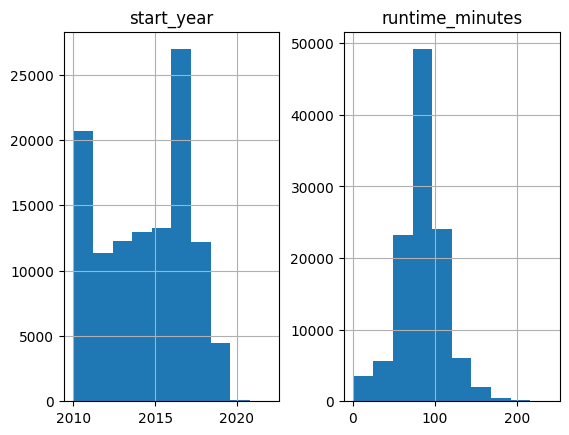

In [60]:
movie_basics_df.hist();

All missingness taken care of. Outliers removed.

### Genres

#### Filling Genre Nulls with TheMovieDB

Actually, we just modified some of our previous data in the notebook, which will help us fill in the missing genre values more accurately. Let's convert the 'data missing' values back to Nulls, so we can compare before and after.

In [61]:
#Convert missing values back to NaN
movie_basics_df['genres'] = movie_basics_df['genres'].replace('data missing', np.nan)

In [62]:
movie_basics_df['genres'].info()

<class 'pandas.core.series.Series'>
Index: 114198 entries, 0 to 146142
Series name: genres
Non-Null Count   Dtype 
--------------   ----- 
112033 non-null  object
dtypes: object(1)
memory usage: 1.7+ MB


There are a lot of moving parts to this imputation. Let's state our conditions clearly.

In [63]:
#Creating a test dataframe first to account for error
#Will run code with test_df, then replace with original dataframe
test_df = movie_basics_df.copy()

In [64]:
test_df['genres'].info()

<class 'pandas.core.series.Series'>
Index: 114198 entries, 0 to 146142
Series name: genres
Non-Null Count   Dtype 
--------------   ----- 
112033 non-null  object
dtypes: object(1)
memory usage: 1.7+ MB


In [65]:
#Stating conditions that must be met for imputation to occur
conditions = (
    movie_basics_df['genres'].isna() &
    (
        (movie_basics_df['primary_title'].isin(tmdb_df['title'])) |
        (movie_basics_df['original_title'].isin(tmdb_df['title']))
    )
)

#Convert 'genres' column to lists
movie_basics_df['genres'] = movie_basics_df['genres'].apply(lambda x: [] if pd.isna(x) else x)

#Iterate over rows where conditions are met
for index, row in movie_basics_df[conditions].iterrows():
    primary_title = row['primary_title']
    original_title = row['original_title']
    #Filter based on conditions
    filtered_tmdb = tmdb_df[
        (tmdb_df['original_title'] == original_title) |
        (tmdb_df['title'] == primary_title)
    ]
    #Append to lists
    genres_list = filtered_tmdb['genre_names'].explode().tolist()
    movie_basics_df.at[index, 'genres'].extend(genres_list)

#Return emmpy lists back to NaN
movie_basics_df['genres'] = movie_basics_df['genres'].apply(lambda x: np.nan if len(x) == 0 else x)

In [66]:
movie_basics_df['genres'].info()

<class 'pandas.core.series.Series'>
Index: 114198 entries, 0 to 146142
Series name: genres
Non-Null Count   Dtype 
--------------   ----- 
112139 non-null  object
dtypes: object(1)
memory usage: 5.8+ MB


Looks like that filled about a hundred missing rows. Not as many as we could have hoped for, but it's a start.

Let's create a merged dataframe to look at the 'movie_id' and 'id' values for these two datasets. If they're identical for each film, we can use those to further fill missing values where the title columns did not work.

In [67]:
#Using the same conditions as before
#Create a filtered dataframe based on these conditions
filtered_movie_basics = movie_basics_df[conditions]

merged_df = pd.merge(filtered_movie_basics, tmdb_df, left_on='original_title', right_on='title', how='inner')

result_df = merged_df[['primary_title', 'movie_id', 'id', 'title']]
result_df.head(50)

,primary_title,movie_id,id,title
0,The Overnight,tt0326592,308024,The Overnight
1,Empire,tt10188180,128822,Empire
2,Nature,tt10199902,103812,Nature
3,Cut,tt10465900,34685,Cut
4,I'm Still Here,tt1701997,43939,I'm Still Here
5,One Night Stand,tt1726707,286486,One Night Stand
6,One Night Stand,tt1726707,396389,One Night Stand
7,Sauvage,tt1756719,518496,Sauvage
8,The Little Match Makers,tt1865524,193287,The Little Match Makers
9,Utopians,tt1913193,385879,Utopians


Unfortunately, these id numbers do not match up. However, an interesting take away from merging this data is that the tmdb_df seems to have duplicate records of the same film, with different id numbers.

#### Filling Genre Nulls with Rotten Tomatoes
We can try and do the same thing we did above with TheMovieDB data, using our Rotten Tomatoes data, since it also contains information about each films genre.

However, first we'll have to do some cleaning. We'll be merging/filtering by different columns now: using the 'director' and 'writer' values of a film to cross reference between the rt and imdb datasets.

For this operation, we'll have to navigate our IMDB SQL database, using the **persons**, **directors**, and **writers** tables through their shared 'person_id's.

Let's finish exploring all of these tables, before returning to this task.

We want to unpack the 'genres' column into distict columns for better genre slicing and analysis

***NOTE: This maybe should come later in feature engineering (or not at all), putting it in for now***

# We will use 0 or 1 instead of True and False for easier analysis later on

def split_genres(genres):
    """
    takes a string input comma delimeted
    returns a list of words
    """
    genre_list = []
    if genres != None:     
        for genre in genres.split(','):
            genre_list.append(genre)
    return genre_list

def assign_genre(row):
    """
    takes a row from df and 
    assigns True to any field that is in the row.genres
    returns the modified row
    """
    genres = split_genres(row['genres'])
    for genre in genres:
        row[genre] = 1
    return row

# Loop through the genres column and collect all distinct genres keywords
genres_set = set([])
for genres in movie_basics_df.genres:
    for word in split_genres(genres):
        genres_set.add(word)

# Create a column in the df for each distinct genre, instantiate with 0
for genre in genres_set:
    movie_basics_df[genre] = 0
        
# Assign 1 to any of the new genre fields whos row 'genres' field contains that genre
movie_basics_df = movie_basics_df.apply(assign_genre, axis=1)


#Convert genres set to list in order to plot
genres_list = list(genres_set)
#Plot
genre_sums = movie_basics_df[genres_list].sum().sort_values(ascending=False)
genre_sums.plot(kind='bar');

___

## "Connecter Tables": known_for, directors, writers
Let's take a look at 'connector' tables.

In [68]:
known_for_df = pd.read_sql("""
                    SELECT *
                    FROM
                        known_for
                    """, conn)
known_for_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638260 entries, 0 to 1638259
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   person_id  1638260 non-null  object
 1   movie_id   1638260 non-null  object
dtypes: object(2)
memory usage: 25.0+ MB


In [69]:
directors_df = pd.read_sql("""
                    SELECT *
                    FROM
                        directors
                    """, conn)
directors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291174 entries, 0 to 291173
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   291174 non-null  object
 1   person_id  291174 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


In [70]:
writers_df = pd.read_sql("""
                    SELECT *
                    FROM
                        writers
                    """, conn)
writers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255873 entries, 0 to 255872
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   255873 non-null  object
 1   person_id  255873 non-null  object
dtypes: object(2)
memory usage: 3.9+ MB


#### No missingness in the 'connector' tables lets move on

___

## Persons
Exploring the persons table.

In [71]:
persons_df = pd.read_sql("""
                    SELECT *
                    FROM
                        persons
                    """, conn)
df_report(persons_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB
None

         birth_year   death_year
count  82736.000000  6783.000000
mean    1967.043826  2000.523367
std       22.122190    43.951530
min        1.000000    17.000000
25%     1957.000000  2001.000000
50%     1971.000000  2013.000000
75%     1981.000000  2016.000000
max     2014.000000  2019.000000

   person_id       primary_name  birth_year  death_year  \
0  nm0061671  Mary Ellen Bauder         NaN         NaN   
1  nm0061865       Joseph Bauer         NaN         NaN   
2  nm0

##### key fields here are person_id, primary_name and they are not missing data.  We will probably not use the other columns, lets move on

___

## Principals
Exploring the principals table.

In [72]:
principals_df = pd.read_sql("""
                    SELECT *
                    FROM
                        principals
                    """, conn)
df_report(principals_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   movie_id    1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   person_id   1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB
None

           ordering
count  1.028186e+06
mean   4.739847e+00
std    2.747446e+00
min    1.000000e+00
25%    2.000000e+00
50%    4.000000e+00
75%    7.000000e+00
max    1.000000e+01

    movie_id  ordering  person_id  category       job        characters
0  tt0111414         1  nm0246005     actor      None       ["The Man"]
1  tt0111414         2  nm0398271  director      None              None
2  tt0111414         3  nm3739909  producer  producer              None
3  tt0323808        10  nm

##### The only missingness here is in job and characters, and we might not even use this table lets move on

___

## Movie Akas
Exploring the movie_akas table.

In [73]:
movie_akas_df = pd.read_sql("""
                    SELECT *
                    FROM
                        movie_akas
                    """, conn)
df_report(movie_akas_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           331703 non-null  object 
 1   ordering           331703 non-null  int64  
 2   title              331703 non-null  object 
 3   region             278410 non-null  object 
 4   language           41715 non-null   object 
 5   types              168447 non-null  object 
 6   attributes         14925 non-null   object 
 7   is_original_title  331678 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 20.2+ MB
None

            ordering  is_original_title
count  331703.000000      331678.000000
mean        5.125872           0.134769
std         6.706664           0.341477
min         1.000000           0.000000
25%         1.000000           0.000000
50%         2.000000           0.000000
75%         6.000000           0.000000
max        

#### is_original_title
Whats going on with is_original_title?

In [74]:
movie_akas_df.is_original_title.value_counts()

is_original_title
0.0    286978
1.0     44700
Name: count, dtype: int64

Looks like boolean coded as 0, 1.  Only 25 missing, we probably wont use it.

#### Title
What does the 'title' column represent?

In [75]:
movie_akas_df['title'].head()

0                              Джурасик свят
1                          Jurashikku warudo
2    Jurassic World: O Mundo dos Dinossauros
3                    O Mundo dos Dinossauros
4                             Jurassic World
Name: title, dtype: object

#### Region
Taking a look at region, might be important

In [76]:
movie_akas_df.region.value_counts().sort_values(ascending=False).head(15)

region
US     51490
XWW    18467
RU     13817
DE     11634
FR     10990
ES      9007
GB      8942
CA      8871
PL      8691
IN      8435
BR      8167
IT      7983
GR      6311
JP      6308
HU      6258
Name: count, dtype: int64

We should fill in missingness of all categorical fields with 'data missing', some of this might be useful

In [77]:
#List of columns to fill
fill_columns = ['region', 'language', 'types', 'attributes']
#Replace missing data with 'data missing'
movie_akas_df[fill_columns] = movie_akas_df[fill_columns].fillna('data missing')
movie_akas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           331703 non-null  object 
 1   ordering           331703 non-null  int64  
 2   title              331703 non-null  object 
 3   region             331703 non-null  object 
 4   language           331703 non-null  object 
 5   types              331703 non-null  object 
 6   attributes         331703 non-null  object 
 7   is_original_title  331678 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 20.2+ MB


___

## Movie Ratings
Our last table to explore...movie_ratings.

*Note that, in addition to movie_basics, this will be one of our two most relevant tables!

In [78]:
movie_ratings_df = pd.read_sql("""
                    SELECT *
                    FROM
                        movie_ratings
                    """, conn)
df_report(movie_ratings_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB
None

       averagerating      numvotes
count   73856.000000  7.385600e+04
mean        6.332729  3.523662e+03
std         1.474978  3.029402e+04
min         1.000000  5.000000e+00
25%         5.500000  1.400000e+01
50%         6.500000  4.900000e+01
75%         7.400000  2.820000e+02
max        10.000000  1.841066e+06

     movie_id  averagerating  numvotes
0  tt10356526            8.3        31
1  tt10384606            8.9       559
2   tt1042974            6.4        20
3   tt1043726            4.2     50352
4   tt1060240            6.5        21


### Null Values
No missingness. Let's look at the distributions.

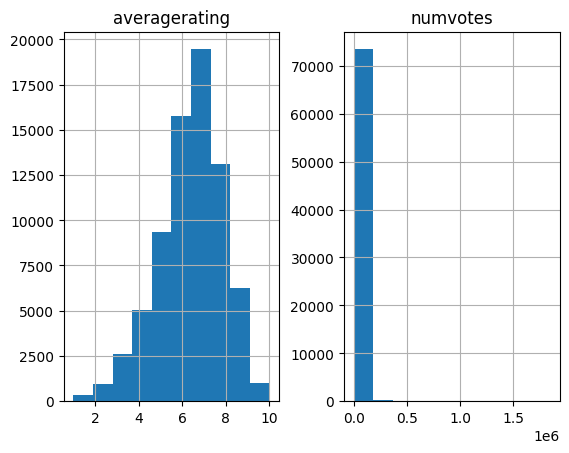

In [79]:
movie_ratings_df.hist();

##### averagerating looks ok, look deeper at numvotes

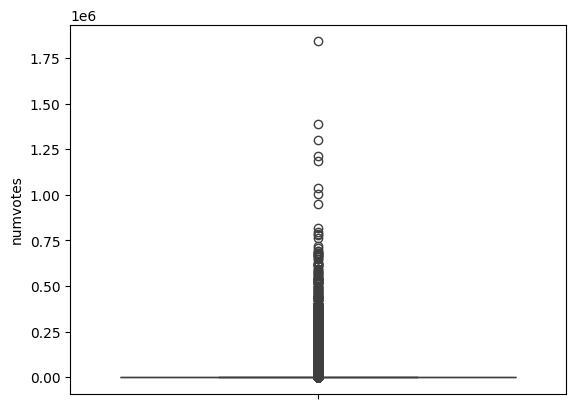

In [80]:
sns.boxplot(movie_ratings_df.numvotes);

In [81]:
movie_ratings_df.query('numvotes > 1000000')

,movie_id,averagerating,numvotes
3140,tt1130884,8.1,1005960
8738,tt1345836,8.4,1387769
24920,tt0816692,8.6,1299334
38058,tt1853728,8.4,1211405
39356,tt0993846,8.2,1035358
48221,tt0848228,8.1,1183655
63498,tt1375666,8.8,1841066


No crazy outliers, it appears to be exponential distribution, lets look at log:

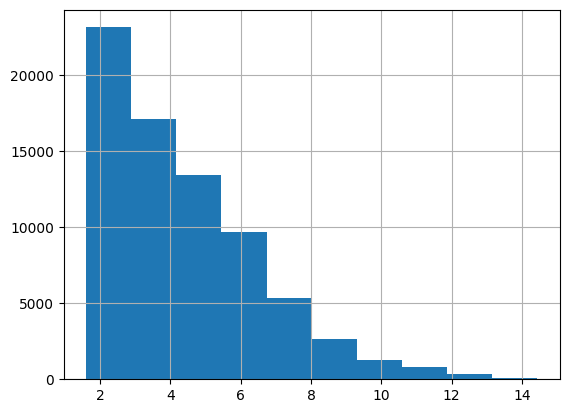

In [82]:
np.log(movie_ratings_df.numvotes).hist();

Probably won't matter but lets do it anyway for potential modeling(?). Add a column for log(numvotes)

In [83]:
movie_ratings_df['log_numvotes'] = np.log(movie_ratings_df.numvotes)

In [84]:
df_report(movie_ratings_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
 3   log_numvotes   73856 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.3+ MB
None

       averagerating      numvotes  log_numvotes
count   73856.000000  7.385600e+04  73856.000000
mean        6.332729  3.523662e+03      4.374729
std         1.474978  3.029402e+04      2.201129
min         1.000000  5.000000e+00      1.609438
25%         5.500000  1.400000e+01      2.639057
50%         6.500000  4.900000e+01      3.891820
75%         7.400000  2.820000e+02      5.641907
max        10.000000  1.841066e+06     14.425855

     movie_id  averagerating  numvotes  log_numvotes
0  tt10356526            8.3        31      3.433987
1  tt1038460

In [85]:
movie_basics_df['runtime_minutes'].value_counts()

runtime_minutes
90.0     7131
80.0     3526
85.0     2915
100.0    2662
95.0     2549
         ... 
229.0       1
213.0       1
187.0       1
221.0       1
234.0       1
Name: count, Length: 240, dtype: int64

___

### Filling Genre Nulls Using Writer/Director

Back to our previous task of using Rotten Tomatoes to fill some more of our null genre values.

As a reminder...for this operation, we'll have to navigate our IMDB SQL database, using the **persons**, **directors**, and **writers** tables through their shared 'person_id's.

(In trying to execute this code, we've run into some errors and unusually long run-times, due to dealing with multiple large datasets. We have edited the code, trying to clean and drop duplicate info throughout to help)

In [86]:
#Merging for directors
merged_directors = pd.merge(directors_df, persons_df, on='person_id', how='left')
merged_directors = pd.merge(movie_basics_df, merged_directors, on='movie_id', how='left')

#Merging for writers
merged_writers = pd.merge(writers_df, persons_df, on='person_id', how='left')
merged_writers = pd.merge(movie_basics_df, merged_writers, on='movie_id', how='left')

#Define function to join names
def join_names(names):
    cleaned_names = [str(name) for name in names if not pd.isnull(name)]
    return ', '.join(cleaned_names)

#Creating separate columns for each
merged_directors['director'] = merged_directors.groupby('movie_id')['primary_name'].transform(join_names)
merged_writers['writer'] = merged_writers.groupby('movie_id')['primary_name'].transform(join_names)

#Drop duplicates
merged_directors = merged_directors.drop_duplicates(subset=['movie_id', 'director'])
merged_writers = merged_writers.drop_duplicates(subset=['movie_id', 'writer'])

In [87]:
#Create new dataframe  with all the relevant data
writers_directors_df = movie_basics_df[['movie_id', 'primary_title', 'genres']]
writers_directors_df = pd.merge (writers_directors_df, merged_directors[['movie_id', 'director']], on='movie_id', how='left')
writers_directors_df = pd.merge (writers_directors_df, merged_writers[['movie_id', 'writer']], on='movie_id', how='left')

writers_directors_df.head(50)

,movie_id,primary_title,genres,director,writer
0,tt0063540,Sunghursh,"Action,Crime,Drama","Harnam Singh Rawail, Harnam Singh Rawail, Harn...","Abrar Alvi, Mahasweta Devi, Gulzar, Anjana Rawail"
1,tt0066787,One Day Before the Rainy Season,"Biography,Drama",Mani Kaul,
2,tt0069049,The Other Side of the Wind,Drama,"Orson Welles, Orson Welles","Orson Welles, Oja Kodar"
3,tt0100275,The Wandering Soap Opera,"Comedy,Drama,Fantasy","Valeria Sarmiento, Raoul Ruiz, Valeria Sarmien...","Pía Rey, Pía Rey, Raoul Ruiz, Raoul Ruiz"
4,tt0111414,A Thin Life,Comedy,Frank Howson,Frank Howson
5,tt0137204,Joe Finds Grace,"Adventure,Animation,Comedy",Anthony Harrison,Anthony Harrison
6,tt0144449,Nema aviona za Zagreb,Biography,Louis van Gasteren,Joke Meerman
7,tt0146592,Pál Adrienn,Drama,"Ágnes Kocsis, Ágnes Kocsis","Ágnes Kocsis, Andrea Roberti"
8,tt0154039,So Much for Justice!,History,Miklós Jancsó,Miklós Jancsó
9,tt0159369,Cooper and Hemingway: The True Gen,Documentary,John Mulholland,John Mulholland


In [88]:
writers_directors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114198 entries, 0 to 114197
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   movie_id       114198 non-null  object
 1   primary_title  114198 non-null  object
 2   genres         112139 non-null  object
 3   director       114198 non-null  object
 4   writer         114198 non-null  object
dtypes: object(5)
memory usage: 4.4+ MB


#### Cleaning Names
Some of the cells in our writers_directors_df from the IMDB dataset have duplicate values such as "Ramin Bahrani, Ramin Bahrani, Ramin Bahrani" in row 43. Let's clean these.

Since we'll be revisiting our Rotten Tomatoes data, to cross reference between identical writer & director values, we'll have to clean and format that data as well.

In [89]:
#Cleaning imdb writers_directors_df
#Split & clean director column
writers_directors_df['director'] = writers_directors_df['director'].str.split(', ').apply(lambda x: ', '.join(sorted(set(x), key=x.index)))
#Split & clean writer column
writers_directors_df['writer'] = writers_directors_df['writer'].str.split(', ').apply(lambda x: ', '.join(sorted(set(x), key=x.index)))

In [90]:
writers_directors_df.head(50)

,movie_id,primary_title,genres,director,writer
0,tt0063540,Sunghursh,"Action,Crime,Drama",Harnam Singh Rawail,"Abrar Alvi, Mahasweta Devi, Gulzar, Anjana Rawail"
1,tt0066787,One Day Before the Rainy Season,"Biography,Drama",Mani Kaul,
2,tt0069049,The Other Side of the Wind,Drama,Orson Welles,"Orson Welles, Oja Kodar"
3,tt0100275,The Wandering Soap Opera,"Comedy,Drama,Fantasy","Valeria Sarmiento, Raoul Ruiz","Pía Rey, Raoul Ruiz"
4,tt0111414,A Thin Life,Comedy,Frank Howson,Frank Howson
5,tt0137204,Joe Finds Grace,"Adventure,Animation,Comedy",Anthony Harrison,Anthony Harrison
6,tt0144449,Nema aviona za Zagreb,Biography,Louis van Gasteren,Joke Meerman
7,tt0146592,Pál Adrienn,Drama,Ágnes Kocsis,"Ágnes Kocsis, Andrea Roberti"
8,tt0154039,So Much for Justice!,History,Miklós Jancsó,Miklós Jancsó
9,tt0159369,Cooper and Hemingway: The True Gen,Documentary,John Mulholland,John Mulholland


In [91]:
#Now Rotten Tomatoes, lets remind ourself what this data looks like
rt_movieinfo_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [92]:
#Test dataframe first, then substitute with orginal
rt_movieinfo_df_cleaned = rt_movieinfo_df.copy()
#Code worked, let's apply it to original df
rt_movieinfo_df['genre'] = rt_movieinfo_df['genre'].str.replace('|', ',')
rt_movieinfo_df['director'] = rt_movieinfo_df['director'].str.replace('|', ',')
rt_movieinfo_df['writer'] = rt_movieinfo_df['writer'].str.replace('|', ',')
rt_movieinfo_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,"Action and Adventure,Classics,Drama",William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,"Drama,Science Fiction and Fantasy",David Cronenberg,"David Cronenberg,Don DeLillo","Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,"Drama,Musical and Performing Arts",Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,"Drama,Mystery and Suspense",Barry Levinson,"Paul Attanasio,Michael Crichton","Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,"Drama,Romance",Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


Now that our data is clean, we need to impute the missing genre values in movie_basics with information from writers_directors_df and rt_movieinfo_df...linking movie_basics and writers_directors_df by their **shared movie_id**.

In [93]:
#Cleaning past data to help future analysis, adding second movie_id column
movie_basics_df['movie_id_2'] = movie_basics_df['movie_id']
#Setting movie_id as index
writers_directors_df.set_index('movie_id', inplace=True)
movie_basics_df.set_index('movie_id', inplace=True)

In [94]:
#Creating test_df to test code first, then will substitute with original df
movie_basics_df_test = movie_basics_df.copy()
movie_basics_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114198 entries, tt0063540 to tt9916730
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   primary_title    114198 non-null  object 
 1   original_title   114198 non-null  object 
 2   start_year       114198 non-null  int64  
 3   runtime_minutes  114198 non-null  float64
 4   genres           112139 non-null  object 
 5   movie_id_2       114198 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.1+ MB


In [95]:
print(movie_basics_df_test[movie_basics_df_test['genres'].isnull()])

                                                primary_title  \
movie_id                                                        
tt0253093                                        Gangavataran   
tt0306058                                       Second Coming   
tt0330987                             Tiden är en dröm, del 2   
tt0877604                                         Chûshingura   
tt10001940                                   Chalu Dya Tumcha   
...                                                       ...   
tt9906844                Footloose in England's Lake District   
tt9907032   Footloose in London II: 2 Undiscovered and Unu...   
tt9907396                 Footloose in the Cotswolds - Part 1   
tt9907608                 Footloose in the Cotswolds - Part 2   
tt9916730                                              6 Gunn   

                                               original_title  start_year  \
movie_id                                                                    


In [96]:
#Identify rows with Null genre in movie basics
mb_genre_nulls = movie_basics_df['genres'].isnull()

for movie_id, row in movie_basics_df[mb_genre_nulls].iterrows():
    if movie_id in writers_directors_df.index:
        writer = writers_directors_df.loc[movie_id, 'writer']
        director = writers_directors_df.loc[movie_id, 'director']
        matching_rows = rt_movieinfo_df[
            rt_movieinfo_df['writer'].str.contains(writer, na=False, case=False) &
            rt_movieinfo_df['director'].str.contains(director, na=False, case=False)
        ]

        if matching_rows.empty:
            movie_basics_df.at[movie_id, 'genres'] = 'data missing'
        elif matching_rows['genre'].isnull().any():
            movie_basics_df.at[movie_id, 'genres'] = 'data missing'
        else:
            combined_genres = set()
            for genres in matching_rows['genre']:
                combined_genres.update(genres.split(','))
            movie_basics_df.at[movie_id, 'genres'] = list(combined_genres)

In [97]:
#Replace 'data missing' with NaN, so we can see how many NaNs were replaced with real data
movie_basics_df['genres'] = movie_basics_df['genres'].replace('data missing', np.nan)
movie_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114198 entries, tt0063540 to tt9916730
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   primary_title    114198 non-null  object 
 1   original_title   114198 non-null  object 
 2   start_year       114198 non-null  int64  
 3   runtime_minutes  114198 non-null  float64
 4   genres           112140 non-null  object 
 5   movie_id_2       114198 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 10.1+ MB


Looks like that only filled one Null value. Let's try one more thing before moving on. Genre of film is going to be so important to our analysis, that we should try to accurately fill all missingness as best as we can.

First, let's take a look again at some of our Null values.

In [98]:
print(movie_basics_df[movie_basics_df['genres'].isnull()])

                                                primary_title  \
movie_id                                                        
tt0253093                                        Gangavataran   
tt0306058                                       Second Coming   
tt0330987                             Tiden är en dröm, del 2   
tt0877604                                         Chûshingura   
tt10001940                                   Chalu Dya Tumcha   
...                                                       ...   
tt9906844                Footloose in England's Lake District   
tt9907032   Footloose in London II: 2 Undiscovered and Unu...   
tt9907396                 Footloose in the Cotswolds - Part 1   
tt9907608                 Footloose in the Cotswolds - Part 2   
tt9916730                                              6 Gunn   

                                               original_title  start_year  \
movie_id                                                                    


Upon further research, a lot of these (ex. 'Footloose in England's Lake District', 'Footloose in the Cotswolds - Part 1') appear to be documentaries.

### Filtering for Documentaries
How can we filter through our null genre roles, assigning the value 'Documentary' where appropriate? 

If it's a documentary, then the "principals" will not be playing fictional characters. So they'll probably have a 'characters' value of 'self' (since they're playing their real-life selves), or something of the sort. 

Let's examine our principals table from our IMDB SQL, and look at the unique values for 'category'.

In [99]:
principals_df['category'].value_counts()

category
actor                  256718
director               146393
actress                146208
producer               113724
cinematographer         80091
composer                77063
writer                  74357
self                    65424
editor                  55512
production_designer      9373
archive_footage          3307
archive_sound              16
Name: count, dtype: int64

Fantastic! This makes our lives so much easier! There is in fact an entire category entitled 'self'. Let's assign all of the rows where this is the case to the genre 'documentary'.

There may be a few exceptions to this rule. Sometimes actors play "themselves" in fictional, or narrative, TV and Film (for example when David Bowie appears in the film 'Zoolander' as David Bowie)...but it's very rare. To be on the look out for these cases, we'll keep an eye on any outliers that arise on our data later on...but we can feel solid about this imputation.

In [100]:
#Exploring films with principal actors playing "themselves"
print(principals_df[principals_df['category'] == 'self'])

           movie_id  ordering   person_id category   job           characters
97       tt10011682         1   nm0016837     self  None          ["Himself"]
134      tt10022952         1   nm0309540     self  None          ["Himself"]
135      tt10022952         2   nm1108319     self  None          ["Himself"]
136      tt10022952         3   nm5324796     self  None          ["Herself"]
137      tt10022952         4   nm2090098     self  None          ["Himself"]
...             ...       ...         ...      ...   ...                  ...
1028097   tt9592190         1  nm10572086     self  None          ["Himself"]
1028098   tt9592190         2  nm10572087     self  None          ["Himself"]
1028099   tt9592190         3  nm10572088     self  None          ["Himself"]
1028100   tt9592190         4  nm10572089     self  None          ["Herself"]
1028182   tt9692684         2   nm4929530     self  None  ["Herself","Regan"]

[65424 rows x 6 columns]


In [101]:
#Looking at the corresponding titles for these films
doc_rows_principals = principals_df[principals_df['category'] == 'self']
doc_movie_ids = doc_rows_principals['movie_id'].tolist()
doc_movie_basics = movie_basics_df[movie_basics_df.index.isin(doc_movie_ids)]

doc_movie_basics.head(30)

,primary_title,original_title,start_year,runtime_minutes,genres,movie_id_2
movie_id,,,,,,
tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography,tt0144449
tt0159369,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,2013,180.0,Documentary,tt0159369
tt0417750,Hempsters: Plant the Seed,Hempsters: Plant the Seed,2010,90.0,Documentary,tt0417750
tt0436782,A Life in the Death of Joe Meek,A Life in the Death of Joe Meek,2013,122.0,Documentary,tt0436782
tt0441779,My Nappy Roots: A Journey Through Black Hair-i...,My Nappy Roots: A Journey Through Black Hair-i...,2010,90.0,Documentary,tt0441779
tt0457591,Memorias del desarrollo,Memorias del desarrollo,2010,113.0,Drama,tt0457591
tt0460528,One Step Beyond: The True Story of Géraldine F...,One Step Beyond,2012,56.0,Documentary,tt0460528
tt0460957,Texxas Jam '78,Texxas Jam '78,2012,60.0,Documentary,tt0460957
tt0477087,Sid Bernstein Presents...,Sid Bernstein Presents...,2010,100.0,Documentary,tt0477087


As expected, most of these are documentaries. Let's examine how many null values there are before we spend any unecessary time on imputations.

In [102]:
doc_movie_basics[doc_movie_basics['genres'].isnull()].head(50)

,primary_title,original_title,start_year,runtime_minutes,genres,movie_id_2
movie_id,,,,,,
tt10279960,Nachrichten vom großen Krieg 1914-1918,Nachrichten vom großen Krieg 1914-1918,2014,93.0,NaN,tt10279960
tt10441614,Out of Nowhere,Out of Nowhere,2012,118.0,NaN,tt10441614
tt1593300,Scumrun II,Scumrun II,2010,93.0,NaN,tt1593300
tt1602011,Accidental Icon: The Real Gidget Story,Accidental Icon: The Real Gidget Story,2010,60.0,NaN,tt1602011
tt1667684,Live in Brazil,Live in Brazil,2010,84.0,NaN,tt1667684
tt1739995,Adolfo Pérez Esquivel. Otro mundo es posible,Adolfo Pérez Esquivel. Otro mundo es posible,2010,83.0,NaN,tt1739995
tt1762318,Paranormal Camcorder,Paranormal Camcorder,2013,102.0,NaN,tt1762318
tt1792157,Wishes Fulfilled! An Exclusive Cinema Event wi...,Wishes Fulfilled! An Exclusive Cinema Event wi...,2010,145.0,NaN,tt1792157
tt1810601,Façade,Façade,2010,45.0,NaN,tt1810601


Indeed, most of these appear to be music documentaries, fitness videos, historical documentaries, etc! Let's make the imputation.

In [103]:
movie_basics_df.loc[(movie_basics_df.index.isin(doc_movie_ids)), 'genres'] = 'Documentary'

In [104]:
movie_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114198 entries, tt0063540 to tt9916730
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   primary_title    114198 non-null  object 
 1   original_title   114198 non-null  object 
 2   start_year       114198 non-null  int64  
 3   runtime_minutes  114198 non-null  float64
 4   genres           112315 non-null  object 
 5   movie_id_2       114198 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 10.1+ MB


## Filtering by Writers and Directors

There *are* exceptions...but many writers and directors tend to work within a particularly genre. We can iterate over all of the rows in our data frame, and replace missing 'genre' values for a certain writer or director with the **mode** of genres that writer/director usually works with.

Before going any further, we need to clean, merge, and drop columns from our dataframes, in order to narrow our focus. We'll make a new dataframe entirely, in case anything goes wrong and we need to refer back to old/dropped information.

## Dropping Columns
In movie_basics_df, we don't need two columns dedicated to the film's title. All we need is the 'primary_title'. We'll start our new dataframe simply by dropping this column.

In [105]:
films_df = movie_basics_df.drop('original_title', axis=1)

In [106]:
#Merging dataframes to add 'writer' and 'director' columns
films_df = films_df.merge(writers_directors_df[['writer', 'director']], left_index=True, right_index=True)

In [107]:
films_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114198 entries, tt0063540 to tt9916730
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   primary_title    114198 non-null  object 
 1   start_year       114198 non-null  int64  
 2   runtime_minutes  114198 non-null  float64
 3   genres           112315 non-null  object 
 4   movie_id_2       114198 non-null  object 
 5   writer           114198 non-null  object 
 6   director         114198 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 11.0+ MB


#### Below might be a waste of time, or might be really useful. Will return to it if necessary.

We've started writing a code below to create dictionaries of writer/director values and the corresponding genres they work in. We code then find the **mode** of each writer or director's genre values and use this to imputate missing genres on films that were written or directed by the same people. 

However, part of good analysis is accurately assessing what the best use of time is. We'll keep a draft of the beginning of this code below, and will return to it later on if necessary.

___
#Creating dictionaries for writers and directors and their corresponding genres
genre_writer_map = {}
genre_director_map = {}

for index, row in eda_films_df.iterrows():
    genre = row['genres']
    writer = row['writer']
    if not pd.isnull(genre):
        if writer in writer_genre_map:
            if genre not in writer_genre_map[writer]:
                writer_genre_map[writer].append(genre)
        else:
            writer_genre_map_writer = [genre]
___             

# Testing Hypotheses

We've already done a lot of data cleaning and analysis. We could go further down many imputation/cleaning rabitt holes if we wanted...but there is so much data that it could be easy to waste time on things we won't end up using. 

Let's explore our data further to see what we need.

## Profitability Metric

First, we need to define a metric of profitability. Let's add some columns from other data frames to the eda_films_df one we're working with that will help us determine profitability and it's influential factors.

In [108]:
films_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114198 entries, tt0063540 to tt9916730
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   primary_title    114198 non-null  object 
 1   start_year       114198 non-null  int64  
 2   runtime_minutes  114198 non-null  float64
 3   genres           112315 non-null  object 
 4   movie_id_2       114198 non-null  object 
 5   writer           114198 non-null  object 
 6   director         114198 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 11.0+ MB


In [109]:
tn_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4387 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 4387 non-null   int64         
 1   release_date       4387 non-null   datetime64[ns]
 2   movie              4387 non-null   object        
 3   production_budget  4387 non-null   int64         
 4   domestic_gross     4387 non-null   int64         
 5   worldwide_gross    4387 non-null   int64         
 6   year               4387 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(4), object(1)
memory usage: 257.1+ KB


In [110]:
#Renaming movie id for clarity
films_df = films_df.rename(columns={'movie_id_2': 'movie_id'})

#Merge rows for the same films
merged_df = pd.merge(films_df, tn_budgets_df, left_on='primary_title', right_on='movie', how='outer')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116627 entries, 0 to 116626
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   primary_title      114298 non-null  object        
 1   start_year         114298 non-null  float64       
 2   runtime_minutes    114298 non-null  float64       
 3   genres             112415 non-null  object        
 4   movie_id           114298 non-null  object        
 5   writer             114298 non-null  object        
 6   director           114298 non-null  object        
 7   id                 5282 non-null    float64       
 8   release_date       5282 non-null    datetime64[ns]
 9   movie              5282 non-null    object        
 10  production_budget  5282 non-null    float64       
 11  domestic_gross     5282 non-null    float64       
 12  worldwide_gross    5282 non-null    float64       
 13  year               5282 non-null    float64 

##### Duplicate Rows
The increase in Non-Null values suggests there are duplicate rows pertaining to the same film. Let's drop these, the continue **concatenating the dataframes**.

In [111]:
merged_df = merged_df.drop_duplicates(subset=['primary_title'])
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107269 entries, 0 to 116626
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   primary_title      107268 non-null  object        
 1   start_year         107268 non-null  float64       
 2   runtime_minutes    107268 non-null  float64       
 3   genres             105462 non-null  object        
 4   movie_id           107268 non-null  object        
 5   writer             107268 non-null  object        
 6   director           107268 non-null  object        
 7   id                 2037 non-null    float64       
 8   release_date       2037 non-null    datetime64[ns]
 9   movie              2037 non-null    object        
 10  production_budget  2037 non-null    float64       
 11  domestic_gross     2037 non-null    float64       
 12  worldwide_gross    2037 non-null    float64       
 13  year               2037 non-null    float64      

In [112]:
#Adding rows that did not survive the merge
unmatched_rows = tn_budgets_df[~tn_budgets_df['movie'].isin(films_df['primary_title'])]
merged_df = pd.concat([merged_df, unmatched_rows], ignore_index=True)

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109598 entries, 0 to 109597
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   primary_title      107268 non-null  object        
 1   start_year         107268 non-null  float64       
 2   runtime_minutes    107268 non-null  float64       
 3   genres             105462 non-null  object        
 4   movie_id           107268 non-null  object        
 5   writer             107268 non-null  object        
 6   director           107268 non-null  object        
 7   id                 4366 non-null    float64       
 8   release_date       4366 non-null    datetime64[ns]
 9   movie              4366 non-null    object        
 10  production_budget  4366 non-null    float64       
 11  domestic_gross     4366 non-null    float64       
 12  worldwide_gross    4366 non-null    float64       
 13  year               4366 non-null    float64 

In [113]:
#Filling Nulls in new rows

#primary_title, movie
merged_df['primary_title'] = merged_df['primary_title'].fillna(merged_df['movie'])
#start_year, year
merged_df['start_year'] = merged_df['start_year'].fillna(merged_df['year'])

#Drop duplicates again
merged_df = merged_df.drop_duplicates(subset=['primary_title'])

#Drop irrelevant columns
columns_to_drop = ['movie', 'year', 'id', 'release_date']
merged_df = merged_df.drop(columns=columns_to_drop)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109596 entries, 0 to 109597
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   primary_title      109596 non-null  object 
 1   start_year         109596 non-null  float64
 2   runtime_minutes    107268 non-null  float64
 3   genres             105462 non-null  object 
 4   movie_id           107268 non-null  object 
 5   writer             107268 non-null  object 
 6   director           107268 non-null  object 
 7   production_budget  4364 non-null    float64
 8   domestic_gross     4364 non-null    float64
 9   worldwide_gross    4364 non-null    float64
dtypes: float64(5), object(5)
memory usage: 9.2+ MB


In [114]:
#Doing the same thing with bom_df
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010
3,Inception,WB,292600000.0,535700000.0,2010
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010


In [115]:
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2032 non-null   float64
 4   year            3387 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 132.4+ KB


In [116]:
#Merge rows for the same films
merged_df_2 = pd.merge(merged_df, bom_df, left_on='primary_title', right_on='title', how='outer')

merged_df_2 = merged_df_2.drop_duplicates(subset=['primary_title'])
merged_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109597 entries, 0 to 110300
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   primary_title      109596 non-null  object 
 1   start_year         109596 non-null  float64
 2   runtime_minutes    107268 non-null  float64
 3   genres             105462 non-null  object 
 4   movie_id           107268 non-null  object 
 5   writer             107268 non-null  object 
 6   director           107268 non-null  object 
 7   production_budget  4364 non-null    float64
 8   domestic_gross_x   4364 non-null    float64
 9   worldwide_gross    4364 non-null    float64
 10  title              2683 non-null    object 
 11  studio             2679 non-null    object 
 12  domestic_gross_y   2665 non-null    float64
 13  foreign_gross      1632 non-null    float64
 14  year               2683 non-null    float64
dtypes: float64(8), object(7)
memory usage: 13.4+ MB


In [117]:
#Adding rows that did not survive the merge
#First have to rename 'domestic_gross'
bom_df = bom_df.rename(columns={'domestic_gross': 'domestic_gross_y'})
unmatched_rows = bom_df[~bom_df['title'].isin(merged_df['primary_title'])]
merged_df_2 = pd.concat([merged_df_2, unmatched_rows], ignore_index=True)

merged_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110301 entries, 0 to 110300
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   primary_title      109596 non-null  object 
 1   start_year         109596 non-null  float64
 2   runtime_minutes    107268 non-null  float64
 3   genres             105462 non-null  object 
 4   movie_id           107268 non-null  object 
 5   writer             107268 non-null  object 
 6   director           107268 non-null  object 
 7   production_budget  4364 non-null    float64
 8   domestic_gross_x   4364 non-null    float64
 9   worldwide_gross    4364 non-null    float64
 10  title              3387 non-null    object 
 11  studio             3382 non-null    object 
 12  domestic_gross_y   3359 non-null    float64
 13  foreign_gross      2032 non-null    float64
 14  year               3387 non-null    float64
dtypes: float64(8), object(7)
memory usage: 12.6+ MB


In [118]:
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             3387 non-null   object 
 1   studio            3382 non-null   object 
 2   domestic_gross_y  3359 non-null   float64
 3   foreign_gross     2032 non-null   float64
 4   year              3387 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 132.4+ KB


In [119]:
#Filling Nulls in new rows

#primary_title, title
merged_df_2['primary_title'] = merged_df_2['primary_title'].fillna(merged_df_2['title'])
#start_year, year
merged_df_2['start_year'] = merged_df_2['start_year'].fillna(merged_df_2['year'])
#domestic gross
merged_df_2['domestic_gross_x'] = merged_df_2['domestic_gross_x'].fillna(merged_df_2['domestic_gross_y'])

#Drop duplicates again
merged_df_2 = merged_df_2.drop_duplicates(subset=['primary_title'])

#Drop irrelevant columns
columns_to_drop = ['title', 'year', 'domestic_gross_y']
merged_df_2 = merged_df_2.drop(columns=columns_to_drop)
merged_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110300 entries, 0 to 110300
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   primary_title      110300 non-null  object 
 1   start_year         110300 non-null  float64
 2   runtime_minutes    107268 non-null  float64
 3   genres             105462 non-null  object 
 4   movie_id           107268 non-null  object 
 5   writer             107268 non-null  object 
 6   director           107268 non-null  object 
 7   production_budget  4364 non-null    float64
 8   domestic_gross_x   6488 non-null    float64
 9   worldwide_gross    4364 non-null    float64
 10  studio             3381 non-null    object 
 11  foreign_gross      2032 non-null    float64
dtypes: float64(6), object(6)
memory usage: 10.9+ MB


### Foreign Gross & Cleaning
Now let's rename columns for clarity, and fill in our **foreign gross** values where possible, subtracting the domestic gross value from the worldwide gross volue.

In [120]:
#Renaming domestic gross
merged_df_2 = merged_df_2.rename(columns={'domestic_gross_x': 'domestic_gross'})
#Renaming year
merged_df_2 = merged_df_2.rename(columns={'start_year': 'year'})

#Filling foreign gross nulls
merged_df_2['foreign_gross'] = merged_df_2['foreign_gross'].fillna(merged_df_2['worldwide_gross'] - merged_df_2['domestic_gross'])

merged_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110300 entries, 0 to 110300
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   primary_title      110300 non-null  object 
 1   year               110300 non-null  float64
 2   runtime_minutes    107268 non-null  float64
 3   genres             105462 non-null  object 
 4   movie_id           107268 non-null  object 
 5   writer             107268 non-null  object 
 6   director           107268 non-null  object 
 7   production_budget  4364 non-null    float64
 8   domestic_gross     6488 non-null    float64
 9   worldwide_gross    4364 non-null    float64
 10  studio             3381 non-null    object 
 11  foreign_gross      5322 non-null    float64
dtypes: float64(6), object(6)
memory usage: 10.9+ MB


In [121]:
#Assigning our new merged dataframe to films_df
films_df = merged_df_2

# Creating Categorical DataFrames

There are lots of factors that can influence and determine a films 'profitability'. We want to focus on monetary losses and gains, but popularity ratings, notable actors, etc. can help us contextualize our interpretations of EDA on monetary data. 

To keep things clean, and help us isolate certain "buckets" of information when necessary (which can be helpful when trying to avoid jumping to conlusions and assuming "correlations" and "causations" between actually unrelated data)...we have our main dataframe be "films_df" which will contain all of our objective information related to monetary and production-related data. 

Then we can have two other dataframes: one will contain the subjective quantifications of public popularity, film ratings, etc.; the second will contain recognizable artist names (writers, directors, actors), who might have drawn the public eye.

(First, let's see if we have enough information for that to be a valuable next step. Otherwise we'll just keep everything in one dataframe).

## Adding information to Main DataFrame

First, we'll add all of our rating & actor information to films_df, so that we can set a universal index among our dataframes that will make them easier to compare. Then we can split this dataframe into three smaller dataframes, based on column subsets.

# Ratings

First, let's look at all of the data we have on a film's popularity & ratings, and merge where possible.

#### TheMovieDB
Our tmdb_df has a two metrics evaluating popularity that might be useful. According to TheMovieDB, these are how these two metrics are evaluated...

**popularity**: calculated from # of page views, ratings, favorites, and watched lists...it is a "lifetime" score

**vote_average**: a percentage score given to a film on a 10-star scale

**vote_count**: total number of votes

#### IMDB Movie Ratings
Our movie_ratings_df has **averagerating**, which is also on a scale of 10, and **numvotes**. We can use these to normalize the average rating, compared to the number of people who voted for the film.

#### Rotten Tomatoes
Our rt_reviews_df contains a **rating** score. Here's how it's calculated...

**rating**: a percentage that represents the number of positive reviews from professional critics. The score is calculated after a minimum of five reviews are received.

Many of the rows in this dataframe are different ratings for the same film. As you can see below, we checked the unique number of 'film ids', to make sure there is enough unique data for this dataset to be worth our time. There's enough data, that we'll use these ratings to impute missing values wherever possible.

In [122]:
rt_reviews_df['id'].nunique()

1135

# 10-Score Scale

All three of these dataframes have a rating-value derived from public opinion. We'll use these to quanitfy a films popularity, and ignore TheMovieDB's own "popularity" value, since that's very subjective to what the company itself deemed relevant.

In order to **quantify the impact of number of total votes on a particular score** we can draw from our statistical knowledge, using ***confidence intervals***, ***Bayesian stats***, our current ***log number of votes***, etc.

### (Keeping or Splitting DF's)

Since we're only going to be using one rating score, and adding only a column or two related to our lead actors, it might be better to keep it all in one dataframe. However, if we end up adding a lot of columns to account for different statistical variability among ratings related to total voter count, it might be better to have at least two. 

We'll stick with one for now, and will subset into two if it becomes necessary.

## IMDB Movie Ratings

Since our IMDB dataset is our most important, we'll use the 'movie ratings' table from this set to determine the ratings for as many films as possible. Then we can use our tmdb and rt dataframes to fill missing information where necessary.

In [123]:
#merge movie_ratings and film_df on movie id's
merged_df = pd.merge(films_df, movie_ratings_df, on='movie_id', how='left')

In [124]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110300 entries, 0 to 110299
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   primary_title      110300 non-null  object 
 1   year               110300 non-null  float64
 2   runtime_minutes    107268 non-null  float64
 3   genres             105462 non-null  object 
 4   movie_id           107268 non-null  object 
 5   writer             107268 non-null  object 
 6   director           107268 non-null  object 
 7   production_budget  4364 non-null    float64
 8   domestic_gross     6488 non-null    float64
 9   worldwide_gross    4364 non-null    float64
 10  studio             3381 non-null    object 
 11  foreign_gross      5322 non-null    float64
 12  averagerating      62115 non-null   float64
 13  numvotes           62115 non-null   float64
 14  log_numvotes       62115 non-null   float64
dtypes: float64(9), object(6)
memory usage: 12.6+ MB


#### TMDB

In [125]:
#Next imputate missing values with tmdb

#Impute averagerating
for index, row in merged_df.iterrows():
    if pd.isnull(row['averagerating']) and row['primary_title'] in tmdb_df['title'].values:
        merged_df.at[index, 'averagerating'] = tmdb_df.loc[tmdb_df['title'] == row['primary_title'], 'vote_average'].values[0]

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110300 entries, 0 to 110299
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   primary_title      110300 non-null  object 
 1   year               110300 non-null  float64
 2   runtime_minutes    107268 non-null  float64
 3   genres             105462 non-null  object 
 4   movie_id           107268 non-null  object 
 5   writer             107268 non-null  object 
 6   director           107268 non-null  object 
 7   production_budget  4364 non-null    float64
 8   domestic_gross     6488 non-null    float64
 9   worldwide_gross    4364 non-null    float64
 10  studio             3381 non-null    object 
 11  foreign_gross      5322 non-null    float64
 12  averagerating      62823 non-null   float64
 13  numvotes           62115 non-null   float64
 14  log_numvotes       62115 non-null   float64
dtypes: float64(9), object(6)
memory usage: 12.6+ MB


In [126]:
#Imputing numvotes
for index, row in merged_df.iterrows():
    if pd.isnull(row['numvotes']) and row['primary_title'] in tmdb_df['title'].values:
        merged_df.at[index, 'numvotes'] = tmdb_df.loc[tmdb_df['title'] == row['primary_title'], 'vote_count'].values[0]

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110300 entries, 0 to 110299
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   primary_title      110300 non-null  object 
 1   year               110300 non-null  float64
 2   runtime_minutes    107268 non-null  float64
 3   genres             105462 non-null  object 
 4   movie_id           107268 non-null  object 
 5   writer             107268 non-null  object 
 6   director           107268 non-null  object 
 7   production_budget  4364 non-null    float64
 8   domestic_gross     6488 non-null    float64
 9   worldwide_gross    4364 non-null    float64
 10  studio             3381 non-null    object 
 11  foreign_gross      5322 non-null    float64
 12  averagerating      62823 non-null   float64
 13  numvotes           62823 non-null   float64
 14  log_numvotes       62115 non-null   float64
dtypes: float64(9), object(6)
memory usage: 12.6+ MB


In [127]:
tmdb_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,genre_names
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"[Adventure, Fantasy, Family]"
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"[Fantasy, Adventure, Animation, Family]"
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"[Adventure, Action, Science Fiction]"
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,"[Animation, Comedy, Family]"
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,"[Action, Science Fiction, Adventure]"


#### RT Data
On second thought, our rotten tomatoes data is not optimally formatted. In order to use this to impute, we'll have to perform calculations in rt_reviews_df that involve splitting each rating by numerator and denominator, and averaging all of the ratings from duplicate movie id's. Then we'll have to cross reference those id's with rt_movieinfo_df, and write code to see where 'director' and 'writer' in rt_movie_df is equal to 'director' and 'writer' in our main films_df.

This is a lot of work, and might be a waste/inefficient use of our time. Let's first determine how many rows exist where avg. rating is Null, and both 'writer' and 'director' are equal to equivalent values in rt_movieinfo_df.

In [128]:
#Count the columns in films_df that we'd be able to impute
count_null_votes = merged_df[
    merged_df['averagerating'].isnull() &
    merged_df['writer'].isin(rt_movieinfo_df['writer']) &
    merged_df['director'].isin(rt_movieinfo_df['director'])
].shape[0]

print(count_null_votes)

2871


This is a substantial amount of null values that we can fill. Let's do it.

Before we go further, let's set our main df back to 'films_df'.

In [129]:
films_df = merged_df

### Reformatting RT Reviews

Before we try to calculate the mean, median, or mode of various 'ratings' by movie id's, let's see whether or not the ratings vary by id. Or if rotten tomatoes has already averaged that for us. 

In [130]:
#Group and aggregate ratings by id number
ratings_by_id = rt_reviews_df.groupby('id')['rating'].apply(list).reset_index()

#Check values
ratings_by_id.head(25)

,id,rating
0,3,"[3/5, nan, nan, nan, nan, nan, C, 2/5, nan, na..."
1,5,"[nan, 4/5, C+, 3.5/4, nan, nan, 3/5, 2/5, 3/5,..."
2,6,"[2.5/5, 2/4, nan, nan, 3/4, nan, 3/4, 2.5/4, 3..."
3,8,"[4/5, 3.5/4, 2.5/4, nan, C+, 2.5/5, 3/4, nan, ..."
4,10,"[3/5, 2/5, nan, 4/5, nan, 6, 3/4, 2/5, 3/5, 2/..."
5,13,"[3.5/4, 5/10, C+, 3/5, 8, 4/10, 3/4, 2.5/4, 8,..."
6,14,"[3/5, 2/5, D+, C-, C-, nan, nan, D+, 1/4, nan,..."
7,15,"[nan, nan, 3/5, nan, 3/10, 3.5/5, nan, 2/4, 5/..."
8,17,"[3/4, 7, 4/5, B, 4/4, C, 7, 4/4, 3/4, 2.5/5, 3..."
9,19,"[nan, 3/5, 4/5, nan, 2.5/4, 2/4, nan, 4/5, 3/5..."


In [131]:
#Lots of non-numerical values, let's filter them out, and convert letters to numbers where possible
def filter_numeric(values):
    filtered_values = []
    for value in values:
        if pd.isna(value):
            continue

        if pd.api.types.is_numeric_dtype(type(value)):
            filtered_values.append(value)
            continue

        if isinstance(value, str):
            value = value.replace('-', '').replace('+', '')
            if any(char.isdigit() for char in value):
                filtered_values.append(value)
                continue
                
            letter_grade = value.strip().upper()

        #Map letters to corresponding numerical grades
            if letter_grade == 'A':
                filtered_values.append('5/5')
            elif letter_grade == 'B':
                filtered_values.append('4/5')
            elif letter_grade == 'C':
                filtered_values.append('3/5')
            elif letter_grade == 'D':
                filtered_values.append('2/5')
            elif letter_grade == 'F':
                filtered_values.append('1/5')

    return filtered_values
    
ratings_by_id['rating'] = ratings_by_id['rating'].apply(filter_numeric)

ratings_by_id.head(15)

,id,rating
0,3,"[3/5, 3/5, 2/5, 4/5, 2/4, 4/5, 3/4, 3/5, 4/5, ..."
1,5,"[4/5, 3/5, 3.5/4, 3/5, 2/5, 3/5, 3/5, 6/10, 3/..."
2,6,"[2.5/5, 2/4, 3/4, 3/4, 2.5/4, 3/5, 2/5, 3/4, 2..."
3,8,"[4/5, 3.5/4, 2.5/4, 3/5, 2.5/5, 3/4, 4/5, 8/10..."
4,10,"[3/5, 2/5, 4/5, 6, 3/4, 2/5, 3/5, 2/5, 2/5, 3...."
5,13,"[3.5/4, 5/10, 3/5, 3/5, 8, 4/10, 3/4, 2.5/4, 8..."
6,14,"[3/5, 2/5, 2/5, 3/5, 3/5, 2/5, 1/4, 1.5/4, 3/5..."
7,15,"[3/5, 3/10, 3.5/5, 2/4, 5/10, 1/5, 0/5, 1/5, 0..."
8,17,"[3/4, 7, 4/5, 4/5, 4/4, 3/5, 7, 4/4, 3/4, 2.5/..."
9,19,"[3/5, 4/5, 2.5/4, 2/4, 4/5, 3/5, 3/5, 3/5, 1.5..."


In [132]:
#Create column of num_ratings
def count_ratings(values):
    return len(values)

ratings_by_id['num_ratings'] = ratings_by_id['rating'].apply(count_ratings)

In [133]:
#Next create column of the avg. of these ratings
#Define a function that calculates the avg., splitting strings into float numerators and denominators
def avg_ratings(ratings_list):
    avg_ratings = []
    for rating in ratings_list:
        #Replace improperly formatted decimals
        rating = rating.replace('-', '.').replace(' ', '.')
        if '/' in rating:
            numerator, denominator = rating.split('/')
            numerator = float(numerator)
            denominator = float(denominator)
            avg_rating = numerator / denominator
            avg_ratings.append(avg_rating)
        else:
            avg_ratings.append(float(rating))

    #Check if avg_ratings is empty, to avoid deviding by zero
    if avg_ratings:
        return sum(avg_ratings) / len(avg_ratings)
    else:
        return np.nan

#Apply this function to ratings_by_id, creating new column
ratings_by_id['avg_rating'] = ratings_by_id['rating'].apply(avg_ratings)

In [134]:
ratings_by_id.head()

,id,rating,num_ratings,avg_rating
0,3,"[3/5, 3/5, 2/5, 4/5, 2/4, 4/5, 3/4, 3/5, 4/5, ...",113,0.691814
1,5,"[4/5, 3/5, 3.5/4, 3/5, 2/5, 3/5, 3/5, 6/10, 3/...",20,0.685000
2,6,"[2.5/5, 2/4, 3/4, 3/4, 2.5/4, 3/5, 2/5, 3/4, 2...",41,0.592683
3,8,"[4/5, 3.5/4, 2.5/4, 3/5, 2.5/5, 3/4, 4/5, 8/10...",40,0.838750
4,10,"[3/5, 2/5, 4/5, 6, 3/4, 2/5, 3/5, 2/5, 2/5, 3....",61,0.756967


Awesome! Now let's merge our 'writer' and 'director' values from our other rt dataframe, to make our imputations with film_df simpler. Then imputate.

In [135]:
rt_ratings_info = pd.merge(ratings_by_id, rt_movieinfo_df[['id', 'director', 'writer']], on='id', how='left')
rt_ratings_info.head()

,id,rating,num_ratings,avg_rating,director,writer
0,3,"[3/5, 3/5, 2/5, 4/5, 2/4, 4/5, 3/4, 3/5, 4/5, ...",113,0.691814,David Cronenberg,"David Cronenberg,Don DeLillo"
1,5,"[4/5, 3/5, 3.5/4, 3/5, 2/5, 3/5, 3/5, 6/10, 3/...",20,0.685000,Allison Anders,Allison Anders
2,6,"[2.5/5, 2/4, 3/4, 3/4, 2.5/4, 3/5, 2/5, 3/4, 2...",41,0.592683,Barry Levinson,"Paul Attanasio,Michael Crichton"
3,8,"[4/5, 3.5/4, 2.5/4, 3/5, 2.5/5, 3/4, 4/5, 8/10...",40,0.838750,Jay Russell,Gail Gilchriest
4,10,"[3/5, 2/5, 4/5, 6, 3/4, 2/5, 3/5, 2/5, 2/5, 3....",61,0.756967,Jake Kasdan,Mike White


In [136]:
films_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110300 entries, 0 to 110299
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   primary_title      110300 non-null  object 
 1   year               110300 non-null  float64
 2   runtime_minutes    107268 non-null  float64
 3   genres             105462 non-null  object 
 4   movie_id           107268 non-null  object 
 5   writer             107268 non-null  object 
 6   director           107268 non-null  object 
 7   production_budget  4364 non-null    float64
 8   domestic_gross     6488 non-null    float64
 9   worldwide_gross    4364 non-null    float64
 10  studio             3381 non-null    object 
 11  foreign_gross      5322 non-null    float64
 12  averagerating      62823 non-null   float64
 13  numvotes           62823 non-null   float64
 14  log_numvotes       62115 non-null   float64
dtypes: float64(9), object(6)
memory usage: 12.6+ MB


In [137]:
#Define conditions for imputation
conditions = (
    films_df['averagerating'].isnull() &
    films_df['writer'].isin(rt_ratings_info['writer']) &
    films_df['director'].isin(rt_ratings_info['director'])
)

#Define function to imput avgrating 
def impute_avg_rating(row):
    matches = rt_ratings_info[
        (rt_ratings_info['writer'] == row['writer']) &
        (rt_ratings_info['director'] == row['director'])
         ]
    if len(matches) > 0:
        return matches['avg_rating'].mean()
    else:
        return np.nan

#Apply to films_df
films_df.loc[conditions, 'averagerating'] = films_df.loc[conditions].apply(impute_avg_rating, axis=1)

films_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110300 entries, 0 to 110299
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   primary_title      110300 non-null  object 
 1   year               110300 non-null  float64
 2   runtime_minutes    107268 non-null  float64
 3   genres             105462 non-null  object 
 4   movie_id           107268 non-null  object 
 5   writer             107268 non-null  object 
 6   director           107268 non-null  object 
 7   production_budget  4364 non-null    float64
 8   domestic_gross     6488 non-null    float64
 9   worldwide_gross    4364 non-null    float64
 10  studio             3381 non-null    object 
 11  foreign_gross      5322 non-null    float64
 12  averagerating      62827 non-null   float64
 13  numvotes           62823 non-null   float64
 14  log_numvotes       62115 non-null   float64
dtypes: float64(9), object(6)
memory usage: 12.6+ MB


For some reason, this only filled 4 null values, which is not what we had anticipated. There may just have been a lot more 'nan' or 'letter' values in our rt ratings than we would have hoped. 

Let's run an updated count_null_votes (accounting for missing rt_ratings_info), with our updated rt_ratings_info to make sure.

In [138]:
#Count the columns in films_df that we'd be able to impute
count_null_votes = films_df[
    films_df['averagerating'].isnull() &
    films_df['writer'].isin(rt_ratings_info['writer']) &
    merged_df['director'].isin(rt_ratings_info['director']) &
    rt_ratings_info['avg_rating'].notnull() &
    (rt_ratings_info['avg_rating'] > 0)
].shape[0]

print(count_null_votes)

27


It's more than 4 values, but it's not nearly enough to waste any more time on. At least we tried! Let's keep moving.

## Dropping Irrelevant Rows

Now we can drop rows. We should do this before adding any additional data (such as actor info) to our dataframe, so our code can run more smoothly and quickly.

If we have neither a film's **budget**, **gross**, or **rating** values, we won't have any metric to determine any kind of monetary or popularity success. Let's drop rows without any of these values.

In [139]:
films_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110300 entries, 0 to 110299
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   primary_title      110300 non-null  object 
 1   year               110300 non-null  float64
 2   runtime_minutes    107268 non-null  float64
 3   genres             105462 non-null  object 
 4   movie_id           107268 non-null  object 
 5   writer             107268 non-null  object 
 6   director           107268 non-null  object 
 7   production_budget  4364 non-null    float64
 8   domestic_gross     6488 non-null    float64
 9   worldwide_gross    4364 non-null    float64
 10  studio             3381 non-null    object 
 11  foreign_gross      5322 non-null    float64
 12  averagerating      62827 non-null   float64
 13  numvotes           62823 non-null   float64
 14  log_numvotes       62115 non-null   float64
dtypes: float64(9), object(6)
memory usage: 12.6+ MB


In [140]:
#Identify columns by which you're filtering
subset_columns = ['production_budget', 'domestic_gross', 'worldwide_gross', 'foreign_gross', 'averagerating']

#Drop rows where all (NOT any) values in selected columns are NaN
films_df = films_df.dropna(subset=subset_columns, how='all')

films_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65773 entries, 0 to 110299
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   primary_title      65773 non-null  object 
 1   year               65773 non-null  float64
 2   runtime_minutes    62741 non-null  float64
 3   genres             62322 non-null  object 
 4   movie_id           62741 non-null  object 
 5   writer             62741 non-null  object 
 6   director           62741 non-null  object 
 7   production_budget  4364 non-null   float64
 8   domestic_gross     6488 non-null   float64
 9   worldwide_gross    4364 non-null   float64
 10  studio             3381 non-null   object 
 11  foreign_gross      5322 non-null   float64
 12  averagerating      62827 non-null  float64
 13  numvotes           62823 non-null  float64
 14  log_numvotes       62115 non-null  float64
dtypes: float64(9), object(6)
memory usage: 8.0+ MB


## Actor Information
Let's add the names of our principal actors to our data. Then we can finally start performing some tests and analysis!

In [141]:
#First, add 'name' column to principals_df to make merging easier
principals_df = principals_df.merge(persons_df[['person_id', 'primary_name']], on='person_id', how='left')

In [142]:
#Then filter for actors and actress
actor_principals = principals_df[(principals_df['category'].isin(['actor', 'actress']))]

#Now merge with films_df with 'movie_id' matches, under new column 'actors'
merged_actors = (
    actor_principals
    .merge(films_df, left_on='movie_id', right_on='movie_id', how='right')
    .groupby('movie_id')['primary_name']
    .apply(list)
    .reset_index()
)

films_df = films_df.merge(merged_actors, on='movie_id', how='left')

#Renaming the new column
films_df = films_df.rename(columns={'primary_name': 'actors'})

films_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65773 entries, 0 to 65772
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   primary_title      65773 non-null  object 
 1   year               65773 non-null  float64
 2   runtime_minutes    62741 non-null  float64
 3   genres             62322 non-null  object 
 4   movie_id           62741 non-null  object 
 5   writer             62741 non-null  object 
 6   director           62741 non-null  object 
 7   production_budget  4364 non-null   float64
 8   domestic_gross     6488 non-null   float64
 9   worldwide_gross    4364 non-null   float64
 10  studio             3381 non-null   object 
 11  foreign_gross      5322 non-null   float64
 12  averagerating      62827 non-null  float64
 13  numvotes           62823 non-null  float64
 14  log_numvotes       62115 non-null  float64
 15  actors             62741 non-null  object 
dtypes: float64(9), object(

# Profitability Metric
We're almost ready to get into some analysis. Let's finish up defining our profitability metric, filling our gross columns, and adding a 'net_profit' columns.

We can add more columns later if need be.

In [143]:
#Filling worldwide_gross with sum of domestic and foreign
films_df['worldwide_gross'] = films_df.apply(
    lambda row: row['domestic_gross'] + row['foreign_gross'] if pd.isna(row['worldwide_gross']) and pd.notna(row['domestic_gross']) and pd.notna(row['foreign_gross']) else row['worldwide_gross'], axis=1
)

In [144]:
#Filling null domestic with worldwide - foreign
films_df['domestic_gross'] = films_df.apply(
    lambda row: row['worldwide_gross'] - row['foreign_gross'] if pd.isna(row['domestic_gross']) and pd.notna(row['worldwide_gross']) and pd.notna(row['foreign_gross']) else row['domestic_gross'], axis=1
)

#Filling null foreign with worldwide - domestic
films_df['foreign_gross'] = films_df.apply(
    lambda row: row['worldwide_gross'] - row['domestic_gross'] if pd.isna(row['foreign_gross']) and pd.notna(row['domestic_gross']) and pd.notna(row['worldwide_gross']) else row['foreign_gross'], axis=1
)

## Net Profit - Profit Ratio (ppratio)
To create a standardized metric that allows for easy comparison, let's calculate the net profit of each market (worldwide, domestic, foreign), and then find the **proportion of net profit to the amount of money spent on production**...AKA our profit to production budget ratio (or 'ppratio').

This will give us 6 new columns, which is a lot to add to our already large dataframe. However we'll be able to drop more soon, once we determine whether the 'domestic' or 'foreign' market is more profitable.

We will use this as a profitiabiliy metric, along with net-profit. Sometimes one will be more useful than the other. 

We'll be focusing on monetary losses and gains...then draw from our info on public "ratings" to better contextualize our findings.

In [145]:
#Adding worldwide, domestic, and foreign net profits
films_df['ww_netprofit'] = films_df['worldwide_gross'] - films_df['production_budget']
films_df['ww_ppratio'] = films_df['ww_netprofit']/films_df['production_budget']

films_df['d_netprofit'] = films_df['domestic_gross'] - films_df['production_budget']
films_df['d_ppratio'] = films_df['d_netprofit']/films_df['production_budget']

films_df['f_netprofit'] = films_df['foreign_gross'] - films_df['production_budget']
films_df['f_ppratio'] = films_df['f_netprofit']/films_df['production_budget']

In [146]:
films_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65773 entries, 0 to 65772
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   primary_title      65773 non-null  object 
 1   year               65773 non-null  float64
 2   runtime_minutes    62741 non-null  float64
 3   genres             62322 non-null  object 
 4   movie_id           62741 non-null  object 
 5   writer             62741 non-null  object 
 6   director           62741 non-null  object 
 7   production_budget  4364 non-null   float64
 8   domestic_gross     6488 non-null   float64
 9   worldwide_gross    5296 non-null   float64
 10  studio             3381 non-null   object 
 11  foreign_gross      5322 non-null   float64
 12  averagerating      62827 non-null  float64
 13  numvotes           62823 non-null  float64
 14  log_numvotes       62115 non-null  float64
 15  actors             62741 non-null  object 
 16  ww_netprofit       436

# Hypothesis Testing - Short Films
Short films are notoriously awful when it comes to wanting to make money or gain any notoriety, at least in today's day and age. We therefore think they're going to be our least profitable film category with regards to 'runtime', but let's test this hypothesis. 

Short Films: *The Academy of Motion Pictures Arts and Sciences* considers anything under **40 minutes** a short film, and anything above that a Feature Film. 

Let's filter based on this metric using 'runtime_minutes'. First, we'll check whether we can also filter based on 'genres'.

In [147]:
#check how many films have 'Short' as genre
# Initialize a counter
short_count = 0

# Loop over each row in the 'genres' column
for genres_list in films_df['genres']:
    # Check if genres_list is a list (not NaN)
    if isinstance(genres_list, list):
        # Check if 'Short' appears in the list
        if 'Short' in genres_list:
            # Increment the counter
            short_count += 1

# Print the count of 'Short'
print("Number of times 'Short' appears:", short_count)

Number of times 'Short' appears: 0


In [148]:
#filter for short films by runtime
short_films = films_df[films_df['runtime_minutes'] <= 40].copy()

#filter for feature films by runtime
feature_films = films_df[films_df['runtime_minutes'] > 40].copy()

print("Number of short films:", len(short_films))
print("Number of feature films:", len(feature_films))

Number of short films: 386
Number of feature films: 62355


We have thousands more feature films than we do short films. We'll keep this in mind when graphing, in case normalizations are necessary.

## Stating Null and Alternative Hypothesis

**null hypothesis**: short films will have higher or equal profit compared to feature films.

**alternative hypothesis**: short films will have lesser profit compared to feature films.

#### Errors that Might Occur in Our Tests

type 1 error: we find evidence that short films are less profitable, when actually they are equally or more so. 

type 2 error: we find evidence that short films are equally, or more profitable than features, when in reality they are less profitable.

### Two-Sample, Independent, One-Tailed Test

We'll have to check our sample size to figure out whether we need **normal distribution tests**, or **t tests** (although we can always use t-tests for greater accuracy).

For this comparison...we'll use **net profit** as our profitability metric, rather than ppratio. We anticipate features to have a *far* greater net-profit than shorts...and ppratio gives us no concept of huge difference in units of measurements (ex. ratios calculated with tens of dollars VS. millions of dollars)

Let's look at the domestic numbers, since we want to stay in the U.S. market if possible.

#### Confidence Intervals 
Calculating the confidence interval of the **mean difference** between short_films and feature_films with regards to d_netprofit. This will provide insight into how statistically different their values are.

In [149]:
short_films.describe()

,year,runtime_minutes,production_budget,domestic_gross,worldwide_gross,foreign_gross,averagerating,numvotes,log_numvotes,ww_netprofit,ww_ppratio,d_netprofit,d_ppratio,f_netprofit,f_ppratio
count,386.000000,386.000000,2.200000e+01,2.600000e+01,2.500000e+01,2.500000e+01,372.000000,372.000000,306.000000,2.200000e+01,22.000000,2.200000e+01,22.000000,2.200000e+01,22.000000
mean,2014.367876,23.181347,3.357955e+07,3.399657e+07,8.054845e+07,4.543565e+07,7.267742,33.927419,2.502381,5.702574e+07,0.972652,6.196435e+06,-0.020287,1.752542e+07,-0.001572
std,2.659832,11.254010,3.079660e+07,5.305235e+07,1.252711e+08,7.578571e+07,1.506082,213.540877,0.928534,1.103898e+08,2.377143,4.426392e+07,1.216652,5.933315e+07,1.292776
min,2010.000000,1.000000,2.500000e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000,1.609438,-2.900000e+07,-1.000000,-5.178899e+07,-1.000000,-5.000000e+07,-1.000000
25%,2012.000000,14.000000,5.625000e+06,3.694335e+05,1.260000e+06,4.892630e+05,6.500000,6.000000,1.791759,-9.586550e+05,-0.262746,-1.366550e+07,-0.748686,-9.752938e+06,-0.713927
50%,2015.000000,25.000000,2.850000e+07,1.048381e+07,2.714799e+07,1.023296e+07,7.500000,8.000000,2.197225,1.971070e+06,0.113314,-1.628441e+06,-0.520910,-1.513887e+06,-0.333927
75%,2017.000000,31.000000,5.550000e+07,4.297503e+07,7.995860e+07,2.820000e+07,8.300000,16.000000,2.833213,6.161527e+07,1.869863,1.503199e+07,0.402682,-6.020275e+04,-0.005995
max,2019.000000,40.000000,1.030000e+08,1.927699e+08,4.576838e+08,2.700000e+08,10.000000,3877.000000,6.912743,3.652802e+08,9.872437,1.557699e+08,4.209996,1.725103e+08,4.662441


In [150]:
#Finding confidence interval of mean difference for domestic net profit

#Isolating data and checking sample size first
short_d_netprofit = short_films['d_netprofit'].dropna()
feature_d_netprofit = feature_films['d_netprofit'].dropna()

print(short_d_netprofit.info())
print(feature_d_netprofit.info())

<class 'pandas.core.series.Series'>
Index: 22 entries, 4205 to 60778
Series name: d_netprofit
Non-Null Count  Dtype  
--------------  -----  
22 non-null     float64
dtypes: float64(1)
memory usage: 352.0 bytes
None
<class 'pandas.core.series.Series'>
Index: 2014 entries, 15 to 64939
Series name: d_netprofit
Non-Null Count  Dtype  
--------------  -----  
2014 non-null   float64
dtypes: float64(1)
memory usage: 31.5 KB
None


### Errors Likely: Differences in sample size
Our short films sample size for this test is small, less than 30 (which means we'll definitely want to use t-tests). In comparison, our feature films sample size is 2014. That's about 91 times larger.

We can still run some tests to see if any interesting trends arise...but we must keep in mind, we are **very likely to have type 1 or type 2 errors arise**. These tests are most likely to be inconclusive, which is actually unsurprising for a few reasons: we'll revisit these reasons later, after we've tried to run some tests.

Back to calculating *Confidence Intervals*. 

First let's try with our d_netprofit.

In [151]:
#calculating the mean difference
mean_diff = np.mean(feature_d_netprofit) - np.mean(short_d_netprofit)

#calculate pooled standard deviation of this difference
pooled_var = ((len(short_d_netprofit) - 1) * np.var(short_d_netprofit, ddof=1) + (len(feature_d_netprofit) - 1) * np.var(feature_d_netprofit, ddof=1)) / (len(short_d_netprofit) + len(feature_d_netprofit) - 2)
std_diff = np.sqrt(pooled_var * (1 / len(short_d_netprofit) + 1 / len(feature_d_netprofit)))

#calculate standard error using pooled std
std_error = std_diff / np.sqrt(len(short_d_netprofit))

#defining confidence level & degrees of freedom
#substracting 2 from df for independent tests
confidence_level = 0.95
df = len(short_d_netprofit) + len(feature_d_netprofit) - 2

# Calculate confidence interval using t-distribution
lower_bound, upper_bound = stats.t.interval(confidence_level, df, loc=mean_diff, scale=std_error)

print(f"Mean Difference: {mean_diff}")
print(f"Confidence Interval ({confidence_level*100}%): ({lower_bound}, {upper_bound})")

Mean Difference: 2236017.462219012
Confidence Interval (95.0%): (-2577166.9070833195, 7049201.831521343)


### Inaccurate Results: Wide Confidence Interval

The wider the gap between our confidence interval's lower and upper bounds, the more inaccurate our assesment is going to be.

Let's see if we can get more accurate findings using the domestic profit-to-spending ratio (ppratio).

In [152]:
# Isolating data and checking sample size first
short_d_ppratio = short_films['d_ppratio'].dropna()
feature_d_ppratio = feature_films['d_ppratio'].dropna()

print(short_d_ppratio.info())
print(feature_d_ppratio.info())

<class 'pandas.core.series.Series'>
Index: 22 entries, 4205 to 60778
Series name: d_ppratio
Non-Null Count  Dtype  
--------------  -----  
22 non-null     float64
dtypes: float64(1)
memory usage: 352.0 bytes
None
<class 'pandas.core.series.Series'>
Index: 2014 entries, 15 to 64939
Series name: d_ppratio
Non-Null Count  Dtype  
--------------  -----  
2014 non-null   float64
dtypes: float64(1)
memory usage: 31.5 KB
None


In [153]:
#Same sample size as before, let's use t-tests

#Calculating the mean difference
mean_diff = np.mean(feature_d_ppratio) - np.mean(short_d_ppratio)

#Calculate pooled standard deviation of this difference
pooled_var = ((len(short_d_ppratio) - 1) * np.var(short_d_ppratio, ddof=1) + (len(feature_d_ppratio) - 1) * np.var(feature_d_ppratio, ddof=1)) / (len(short_d_ppratio) + len(feature_d_ppratio) - 2)
std_diff = np.sqrt(pooled_var * (1 / len(short_d_ppratio) + 1 / len(feature_d_ppratio)))

#Calculate standard error using pooled std
std_error = std_diff / np.sqrt(len(short_d_ppratio))

#Defining confidence level and degrees of freedom
#Subtracting 2 from df for independent tests
confidence_level = 0.95
df = len(short_d_ppratio) + len(feature_d_ppratio) - 2

#Calculate confidence interval using t-distribution
lower_bound, upper_bound = stats.t.interval(confidence_level, df, loc=mean_diff, scale=std_error)

print(f"Mean Difference: {mean_diff}")
print(f"Confidence Interval ({confidence_level*100}%): ({lower_bound}, {upper_bound})")

Mean Difference: 0.6714256363550258
Confidence Interval (95.0%): (0.14658748219570994, 1.1962637905143416)


This is a much more accurate assesment than our prior assesment - with a much smaller confidence interval.

The findings of this test suggest that there is a **95% chance the mean of feature dppratio will be 0.15 - 1.2 higher than that of short films**.

## T-Test: Finding `p_value` (alpha of 0.05)

### Determining equal or unequal variance
Before we can run a test to determine the p-value of the d_ppratio mean differences between short and feature films, we need to assess whether our populations have equal or unequal variances. 

Let's use box plots and see if we notice any drastic differences in size.

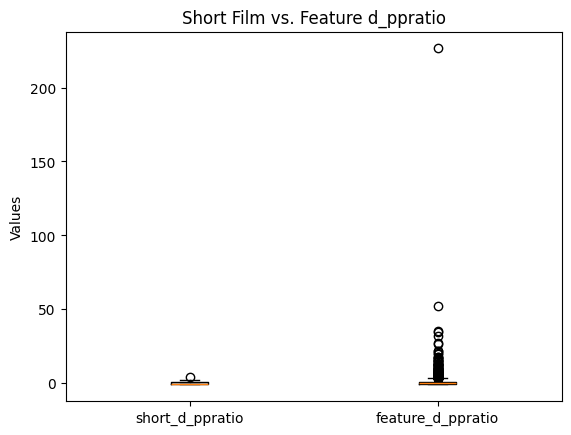

In [154]:
#plotting boxplot
fig, ax = plt.subplots()
ax.boxplot([short_d_ppratio, feature_d_ppratio])
#add labels
ax.set_xticklabels(['short_d_ppratio', 'feature_d_ppratio'])

#add title and labels
ax.set_title('Short Film vs. Feature d_ppratio')
ax.set_ylabel('Values')

# Show the plot
plt.show()

### Filtering Outliers
Looks like we have an outlier in feature_d_ppratio, that's making our box plots hard to read. Let's filter it out to get a better look.

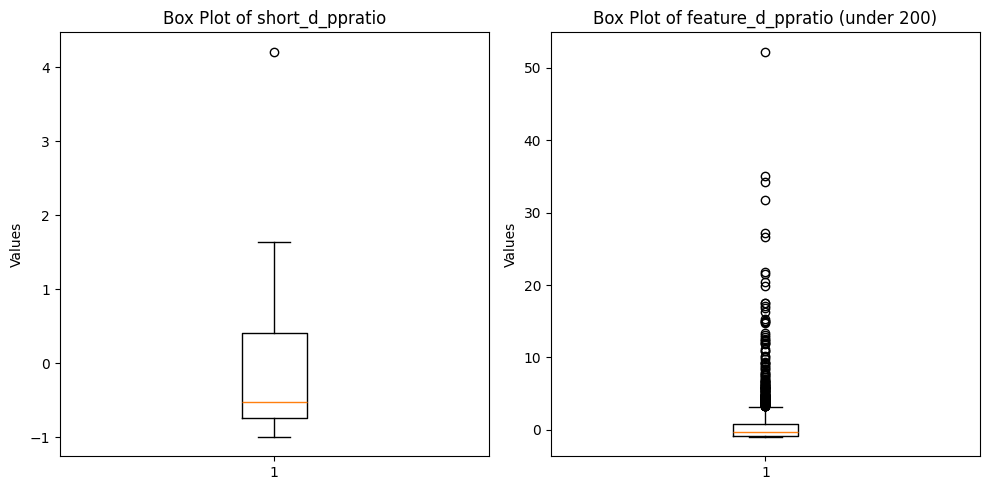

In [155]:
#Same plot, but filter out outliers greater than 200
#Define threshold and filter feature dppratio
threshold = 200
filter_feature_d_ppratio = feature_d_ppratio[feature_d_ppratio <= threshold]

# Create a figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot boxplot for short_d_ppratio
axs[0].boxplot(short_d_ppratio)
axs[0].set_title('Box Plot of short_d_ppratio')
axs[0].set_ylabel('Values')

# Plot boxplot for filtered_feature_d_ppratio
axs[1].boxplot(filter_feature_d_ppratio)
axs[1].set_title('Box Plot of feature_d_ppratio (under 200)')
axs[1].set_ylabel('Values')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Levene's Test
There are so many fliers in our feature boxplot. Let's not rely on our visual perception alone.

Let's try using Levene's Test **with a 0.05 alpha** to determine equality, or lack thereof, of variances between our two independent samples.

*null hypothesis*: the groups have equal variance

*alternative hypothesis*: the groups do not have equal variance

In [156]:
#import from scipy stats
from scipy.stats import levene

#performing levene's test
statistic, p_value = levene(short_d_ppratio, feature_d_ppratio)

print("statistic:", statistic)
print("p_value:", p_value)

statistic: 0.3014427797586318
p_value: 0.5830396030121953


#### Equal Variances: failure to reject null hypothesis
Our p-value must be smaller than our alpha (0.05) if we want to reject the null hypothesis. Therefore, we must operate under the assumption that our samples have equal variance.

Let's go back to our tests on the mean differences between our d_ppratio's. We'll perform a manual calculation **and** stats.ttest_ind, to compare values and more safely account for errors due to drastically different sample sizes.

In [157]:
#using manual calculation
t_stat_manual = mean_diff / std_error
p_value_manual = stats.t.cdf(t_stat_manual, df)

#using stats.ttest_ind, assuming equal variance
t_statistic, p_value = stats.ttest_ind(short_d_ppratio, feature_d_ppratio, equal_var=True)

print("Manual Calculation")
print(f"t-stat: {t_stat_manual}, p-value: {p_value_manual}")
print()
print("Using stats.ttest_ind")
print(f"t-stat: {t_statistic}, p-value: {p_value}")

Manual Calculation
t-stat: 2.5088755509307403, p-value: 0.9939055845685977

Using stats.ttest_ind
t-stat: -0.5348940647055106, p-value: 0.592781580063048


# Short Films: Inconclusive

There are way too many problems with these tests. Most likely due to one of our samples being 91 times the size of the other. 

Our lack of data on short films domestic gross could be **evidence that short films rarely have any domestic gross**, which would support our hypothesis that they are less profitable.

We cannot reasonably deduce a conclusion either way. In order to do so, we would need more data. We'll narrow our focus to feature films, or films greater than 40-minutes...since they have the greatest evidence of documented profitability across all of our metrics!


In [158]:
#dropping short films from our data
films_df = films_df.drop(films_df[films_df['runtime_minutes'] <= 40].index)

# Profitability by Genre

We're almost ready to get to some real graphing and EDA analysis, to filter through all of the films in our dataset, before we do there's one more hypothesis test we'd like to run.

Before we get there, let's prep our dataset - grouping by relevant categories, and cutting everything we don't need. 

## Filtering out years
Let's take a look again at how our data is distributed by year. 

In [159]:
films_df['year'].value_counts().sort_index()

year
2000.0     154
2001.0     152
2002.0     191
2003.0     176
2004.0     189
2005.0     195
2006.0     236
2007.0     195
2008.0     229
2009.0     207
2010.0    6227
2011.0    6613
2012.0    6761
2013.0    7030
2014.0    7256
2015.0    7300
2016.0    7314
2017.0    7165
2018.0    6080
2019.0    1712
2020.0       5
Name: count, dtype: int64

Way more films post-2010, which is good news for us. We want to be drawing from information relevant to modern-day. 

Let's drop all of the films prior to 2010.

In [183]:
#Dropping films prior to 2010
films_df = films_df[films_df['year'] >= 2010]

#Converting type back to int
films_df['year'] = films_df['year'].astype(int)

## Dropping Irrelevant Columns

In [161]:
drop_columns= ['domestic_gross', 'worldwide_gross', 'foreign_gross', 'log_numvotes', 
              'ww_netprofit', 'ww_ppratio', 'f_netprofit', 'f_ppratio']
films_df = films_df.drop(drop_columns, axis=1)

___
# BELOW DOCUMENTARY HYPOTHESIS TESTING: LEAVING AS MARKDOWN UNTIL CAN BE CLEANED...MIGHT NOT BE WORTH IT

### Hypothesis Testing - Documentaries

The other category of film in our data distinctly separate from narrative feature films, are documentaries. Similar to short films, documentaries are not known for being widely profitable or popular...especially compared to the "blockbuster" narrative feature films we associate with billboards and Hollywood stardom. 

For reference, this is how the

We need to test this hypothesis, before narrowing our focus further.

**null hypothesis**: documentaries will have higher or equal profit compared to feature films.

**alternative hypothesis**: documentaries will have lesser profit compared to feature films.

##### Two-Sample, Independent, One-Tailed Test
Similar to our hypothesis testing of short films, this is going to be a two-sample, independent, one-tailed test. Let's drop Null's and establish our variables so we can examine what sample sizes we're working with.

#Isolating narrative, or non-doc, feature films (ffilms)
narr_ffilms = films_df.copy()
narr_ffilms = narr_ffilms.dropna(subset=['genres'])
#Filter out documentaries
for index, row in narr_ffilms.iterrows():
    # Iterate through elements in 'genres' list
    for element in row['genres']:
        if element == 'Documentary':
            narr_ffilms.drop(index, inplace=True)
            break

#Define variables
narr_d_ppratio = narr_ffilms['d_ppratio'].dropna()
narr_d_netprofit = narr_ffilms['d_netprofit'].dropna()

#Isolating documentary films
#Because some of our 'genres' values are lists, we should iterate over every element
doc_films = films_df.copy()
doc_films = doc_films.dropna(subset=['genres'])
#Filter out non-documentaries
for index, row in doc_films.iterrows():
    if 'Documentary' not in row['genres']:
        doc_films.drop(index, inplace=True)

#Isolating documentary data for domestic profits
doc_d_ppratio = doc_films['d_ppratio'].dropna()
doc_d_netprofit = doc_films['d_netprofit'].dropna()

doc_films.info()

narr_ffilms.info()

### Small Sample Size

Like short films, our sample size is much smaller than the amount of data we have for features. This could similarly be because documentary films simple do not gross domestically like feature films, which leads to smaller amounts of data. However, our sample sizes for documentary films *are* bigger than that of shorts...at 114. We can hope this will allow us to conduct tests that are more conclusive.

Additionally, documentary films have a far greater amount of data for our popularity metrics (avaragerating and numvotes) at 13133...whereas short films only had 372. We can draw from this data as well, to see how it might contextualize our findings with regards to profit.

# Graphing

Since we have more information at our disposal with regards to documentaries, let's do some graphs to get a better visual of our data before testing our hypothesis that documentaries are less profitable than narrative features.

## Documentary vs. Narrative: Domestic Ppratio by Budget

#graphing the dppratio for documentary and narrative films by size of budget

#plotting
plt.plot(narr_ffilms['production_budget'], narr_ffilms['d_ppratio'], label='narr_ffilms', color='red')
plt.plot(doc_films['production_budget'], doc_films['d_ppratio'], label='doc_films', color='blue')

#labels & titles
plt.xlabel('Production Budget')
plt.ylabel('Domestic Profit-to-Budget Ratio')
plt.title('Documentary and Narrative Dppratio by Budget')

plt.legend()

plt.show()

narr_ffilms.describe()

doc_films.describe()

#### Confidence Intervals 
Calculating the confidence interval of the **mean difference** between doc_films and feature_films with regards to d_netprofit and d_ppratio. This will provide insight into how statistically different their values are.

##### D-Netprofit

#calculating the mean difference between domestic net profits
mean_diff = np.mean(narr_d_netprofit) - np.mean(doc_d_netprofit)

#calculate pooled standard deviation of this difference
pooled_var = ((len(doc_d_netprofit) - 1) * np.var(doc_d_netprofit, ddof=1) + (len(narr_d_netprofit) - 1) * np.var(narr_d_netprofit, ddof=1)) / (len(doc_d_netprofit) + len(narr_d_netprofit) - 2)
std_diff = np.sqrt(pooled_var * (1 / len(doc_d_netprofit) + 1 / len(narr_d_netprofit)))

#calculate standard error using pooled std
std_error = std_diff / np.sqrt(len(doc_d_netprofit))

#defining confidence level & degrees of freedom
#substracting 2 from df for independent tests
confidence_level = 0.95
df = len(doc_d_netprofit) + len(narr_d_netprofit) - 2

# Calculate confidence interval using t-distribution
lower_bound, upper_bound = stats.t.interval(confidence_level, df, loc=mean_diff, scale=std_error)

print(f"Mean Difference: {mean_diff}")
print(f"Confidence Interval ({confidence_level*100}%): ({lower_bound}, {upper_bound})")

### Inaccurate Results: Wide Confidence Interval

Once again, we have a wide confidence interval with regards to the mean difference in our d_netprofit.

Let's see if we can get more accurate findings using the domestic profit-to-spending ratio (ppratio).

##### D-Ppratio

#Same sample size as before, let's use t-tests for accuracy

#Calculating the mean difference
mean_diff = np.mean(narr_d_ppratio) - np.mean(doc_d_ppratio)

#Calculate pooled standard deviation of this difference
pooled_var = ((len(doc_d_ppratio) - 1) * np.var(doc_d_ppratio, ddof=1) + (len(narr_d_ppratio) - 1) * np.var(narr_d_ppratio, ddof=1)) / (len(doc_d_ppratio) + len(narr_d_ppratio) - 2)
std_diff = np.sqrt(pooled_var * (1 / len(doc_d_ppratio) + 1 / len(narr_d_ppratio)))

#Calculate standard error using pooled std
std_error = std_diff / np.sqrt(len(doc_d_ppratio))

#Defining confidence level and degrees of freedom
#Subtracting 2 from df for independent tests
confidence_level = 0.95
df = len(doc_d_ppratio) + len(narr_d_ppratio) - 2

#Calculate confidence interval using t-distribution
lower_bound, upper_bound = stats.t.interval(confidence_level, df, loc=mean_diff, scale=std_error)

print(f"Mean Difference: {mean_diff}")
print(f"Confidence Interval ({confidence_level*100}%): ({lower_bound}, {upper_bound})")

The findings of this test suggest that there is a **95% chance the mean of feature dppratio will be 0.16 - 0.36 higher than that of documentary films**.

## T-Test: Finding `p_value` (alpha of 0.05)
### Determining equal or unequal variance

### Levene's Test
Let's start with Leven's Test this time. 

*null hypothesis*: the groups have equal variance

*alternative hypothesis*: the groups do not have equal variance

#performing levene's test
statistic, p_value = levene(doc_d_ppratio, narr_d_ppratio)

print("statistic:", statistic)
print("p_value:", p_value)

#### Equal Variances: failure to reject null hypothesis
P-value is much greater than 0.05 alpha: accept null hypothesis and assume variances are equal.

### T-Tests: manual and stats.ttest_ind

#using manual calculation
t_stat_manual = mean_diff / std_error
p_value_manual = stats.t.cdf(t_stat_manual, df)

#using stats.ttest_ind, assuming equal variance
t_statistic, p_value = stats.ttest_ind(doc_d_ppratio, narr_d_ppratio, equal_var=True)

print("Manual Calculation")
print(f"t-stat: {t_stat_manual}, p-value: {p_value_manual}")
print()
print("Using stats.ttest_ind")
print(f"t-stat: {t_statistic}, p-value: {p_value}")

### p-value > alpha: Fail to Reject Null

## Testing Popularity

Let's test with our popularity metrics: averagerating and numvotes.

For these tests, the direction of our hypothesis is slightly different. Typically, quality of rating does not always align with quantity of ratings...and documentaries are thought of as "less flashy" and "less popular" than narrative films.

Knowing this, we hypothesize that in order for a person to go through the hassle of rating a documentary film online, they most likely have a special commitment to documentary film as a niche. This would make them more likely to give a documentary a *higher rating*.

AKA, we hypothesize that **documentary films will have higher quality average ratings, while narrative features will have a higher volume of vote counts**.

Let's state that clearly in our hypotheses for each of the two metrics...

### Average Rating

null hypothesis: documentary films will have an equal or lesser average rating than narrative features.

alternative hypothesis: documentary films will have a greater average rating than narrative features.

# Isolate necessary data, create variables
doc_avgrating = doc_films['averagerating'].dropna()
doc_numvotes = doc_films['numvotes'].dropna()

narr_avgrating = narr_ffilms['averagerating'].dropna()
narr_numvotes = narr_ffilms['numvotes'].dropna()

#### Confidence Intervals: Avg Rating, Num of Votes
##### Average Rating

#calculating the mean difference between average ratings
mean_diff = np.mean(narr_avgrating) - np.mean(doc_avgrating)

#calculate pooled standard deviation of this difference
pooled_var = ((len(doc_avgrating) - 1) * np.var(doc_avgrating, ddof=1) + (len(narr_avgrating) - 1) * np.var(narr_avgrating, ddof=1)) / (len(doc_avgrating) + len(narr_avgrating) - 2)
std_diff = np.sqrt(pooled_var * (1 / len(doc_avgrating) + 1 / len(narr_avgrating)))

#calculate standard error using pooled std
std_error = std_diff / np.sqrt(len(doc_avgrating))

#defining confidence level & degrees of freedom
#substracting 2 from df for independent tests
confidence_level = 0.95
df = len(doc_avgrating) + len(narr_avgrating) - 2

# Calculate confidence interval using t-distribution
lower_bound, upper_bound = stats.t.interval(confidence_level, df, loc=mean_diff, scale=std_error)

print(f"Mean Difference: {mean_diff}")
print(f"Confidence Interval ({confidence_level*100}%): ({lower_bound}, {upper_bound})")

#calculating the mean difference between average ratings
mean_diff = np.mean(doc_avgrating) - np.mean(narr_avgrating)

#calculate pooled standard deviation of this difference
pooled_var = ((len(doc_avgrating) - 1) * np.var(doc_avgrating, ddof=1) + (len(narr_avgrating) - 1) * np.var(narr_avgrating, ddof=1)) / (len(doc_avgrating) + len(narr_avgrating) - 2)
std_diff = np.sqrt(pooled_var * (1 / len(doc_avgrating) + 1 / len(narr_avgrating)))

#calculate standard error using pooled std
std_error = std_diff / np.sqrt(len(doc_avgrating))

#defining confidence level & degrees of freedom
#substracting 2 from df for independent tests
confidence_level = 0.95
df = len(doc_avgrating) + len(narr_avgrating) - 2

# Calculate confidence interval using t-distribution
lower_bound, upper_bound = stats.t.interval(confidence_level, df, loc=mean_diff, scale=std_error)

print(f"Mean Difference: {mean_diff}")
print(f"Confidence Interval ({confidence_level*100}%): ({lower_bound}, {upper_bound})")

### Levene's Test: Equal or Unequal Variance

Levene's Test **with a 0.05 alpha**...

*null hypothesis*: the groups have equal variance

*alternative hypothesis*: the groups do not have equal variance

#performing levene's test
statistic, p_value = levene(doc_avgrating, narr_avgrating)

print("statistic:", statistic)
print("p_value:", p_value)

### T-Tests: manual and stats.ttest_ind

#using manual calculation
t_stat_manual = mean_diff / std_error
p_value_manual = stats.t.cdf(t_stat_manual, df)

#using stats.ttest_ind, assuming equal variance
t_statistic, p_value = stats.ttest_ind(doc_avgrating, narr_avgrating, equal_var=True)

print("Manual Calculation")
print(f"t-stat: {t_stat_manual}, p-value: {p_value_manual}")
print()
print("Using stats.ttest_ind")
print(f"t-stat: {t_statistic}, p-value: {p_value}")

### Number of Votes

null hypothesis: documentary films will have an equal or greater number of votes than narrative features.

alternative hypothesis: documentary films will have a lesser number of votes than narrative features.

#calculating the mean difference between average ratings
mean_diff = np.mean(narr_numvotes) - np.mean(doc_numvotes)

#calculate pooled standard deviation of this difference
pooled_var = ((len(doc_numvotes) - 1) * np.var(doc_numvotes, ddof=1) + (len(narr_numvotes) - 1) * np.var(narr_numvotes, ddof=1)) / (len(doc_numvotes) + len(narr_numvotes) - 2)
std_diff = np.sqrt(pooled_var * (1 / len(doc_numvotes) + 1 / len(narr_numvotes)))

#calculate standard error using pooled std
std_error = std_diff / np.sqrt(len(doc_numvotes))

#defining confidence level & degrees of freedom
#substracting 2 from df for independent tests
confidence_level = 0.95
df = len(doc_numvotes) + len(narr_numvotes) - 2

# Calculate confidence interval using t-distribution
lower_bound, upper_bound = stats.t.interval(confidence_level, df, loc=mean_diff, scale=std_error)

print(f"Mean Difference: {mean_diff}")
print(f"Confidence Interval ({confidence_level*100}%): ({lower_bound}, {upper_bound})")

#using manual calculation
t_stat_manual = mean_diff / std_error
p_value_manual = stats.t.cdf(t_stat_manual, df)

#using stats.ttest_ind, assuming equal variance
t_statistic, p_value = stats.ttest_ind(doc_numvotes, narr_numvotes, equal_var=True)

print("Manual Calculation")
print(f"t-stat: {t_stat_manual}, p-value: {p_value_manual}")
print()
print("Using stats.ttest_ind")
print(f"t-stat: {t_statistic}, p-value: {p_value}")

# Graphing

## Filter for Financial Data

In [203]:
financials = films_df[films_df.d_netprofit.notna()]

## Grouping by Genre

Loop through all the data and capture 'group' for the top 12 distinct genre catagories, such that if a movie contains the genre in its 'genres' field then it will be part of that group. **Note that a movie can belong to multiple groups**.

Will use these group to perform statistical testing agains the dependent variables further below

In [204]:
groups = ['Documentary', 'Drama', 'Comedy', 'Thriller', 'Horror', 'Biography', 'Action', 'Romance', 
          'Crime', 'History', 'Adventure', 'Family']

df_groups = [films_df[films_df['genres'].str.contains(group, na=False)].assign(group=group) for group in groups]

combined_df = pd.concat(df_groups, ignore_index=True)

combined_df.head()

,primary_title,year,runtime_minutes,genres,movie_id,writer,director,production_budget,studio,averagerating,numvotes,actors,d_netprofit,d_ppratio,group
0,!Women Art Revolution,2010,83.0,Documentary,tt1699720,,Lynn Hershman-Leeson,NaN,NaN,6.9,196.0,[nan],NaN,NaN,Documentary
1,#AbroHilo,2019,52.0,Documentary,tt9844890,Beatriz Cepeda,Antonio J. García,NaN,NaN,6.6,8.0,[nan],NaN,NaN,Documentary
2,#BeRobin the Movie,2015,41.0,Documentary,tt5074174,,Kurt Weitzmann,NaN,NaN,9.0,31.0,[nan],NaN,NaN,Documentary
3,#Disneyland60,2015,45.0,Documentary,tt4902162,M.L. Martin,Kate Scott,NaN,NaN,8.8,5.0,"[Kate Scott, Faust the Artist]",NaN,NaN,Documentary
4,#Female Pleasure,2018,97.0,Documentary,tt8372826,Barbara Miller,Barbara Miller,NaN,NaN,7.6,274.0,[nan],NaN,NaN,Documentary


In [205]:
films_df['year'] = films_df['year'].astype(int)

## Graphs

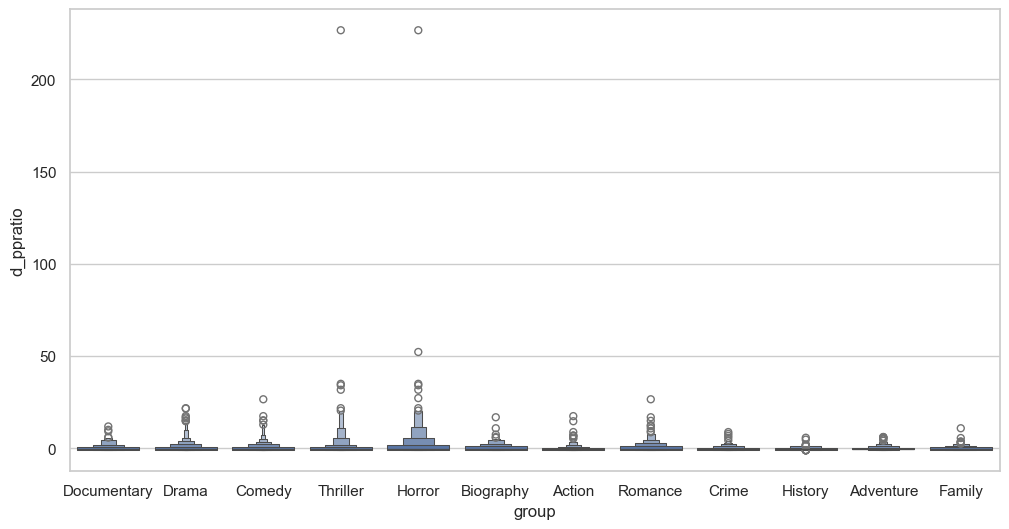

In [206]:
plt.figure(figsize=(12, 6))
sns.boxenplot(x='group', y='d_ppratio', data=combined_df);

In [207]:
combined_df.query('d_ppratio > 150')

,primary_title,year,runtime_minutes,genres,movie_id,writer,director,production_budget,studio,averagerating,numvotes,actors,d_netprofit,d_ppratio,group
61764,The Gallows,2015,81.0,"Horror,Mystery,Thriller",tt2309260,"Chris Lofing, Travis Cluff","Travis Cluff, Chris Lofing",100000.0,WB (NL),4.2,17763.0,"[Reese Mishler, Pfeifer Brown, Ryan Shoos, Cas...",22664410.0,226.6441,Thriller
68146,The Gallows,2015,81.0,"Horror,Mystery,Thriller",tt2309260,"Chris Lofing, Travis Cluff","Travis Cluff, Chris Lofing",100000.0,WB (NL),4.2,17763.0,"[Reese Mishler, Pfeifer Brown, Ryan Shoos, Cas...",22664410.0,226.6441,Horror


In [208]:
combined_df = combined_df.query('d_ppratio < 150')

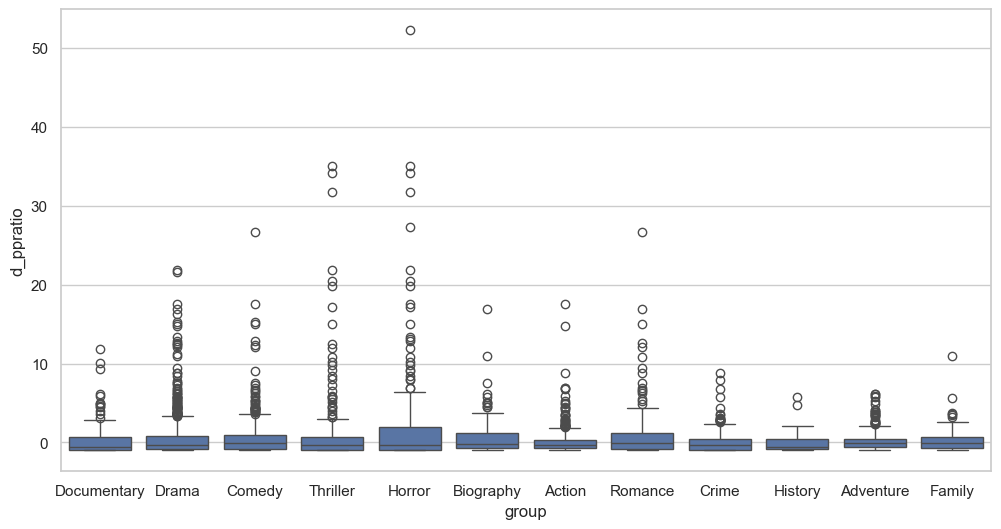

In [209]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='group', y='d_ppratio', data=combined_df);

In [210]:
combined_df.query('d_ppratio > 40')

,primary_title,year,runtime_minutes,genres,movie_id,writer,director,production_budget,studio,averagerating,numvotes,actors,d_netprofit,d_ppratio,group
68026,The Devil Inside,2012,83.0,Horror,tt1560985,"William Brent Bell, Matthew Peterman",William Brent Bell,1000000.0,Par,4.2,33522.0,"[Fernanda Andrade, Simon Quarterman, Evan Helm...",52262945.0,52.262945,Horror


In [211]:
combined_df = combined_df.query('d_ppratio < 40')

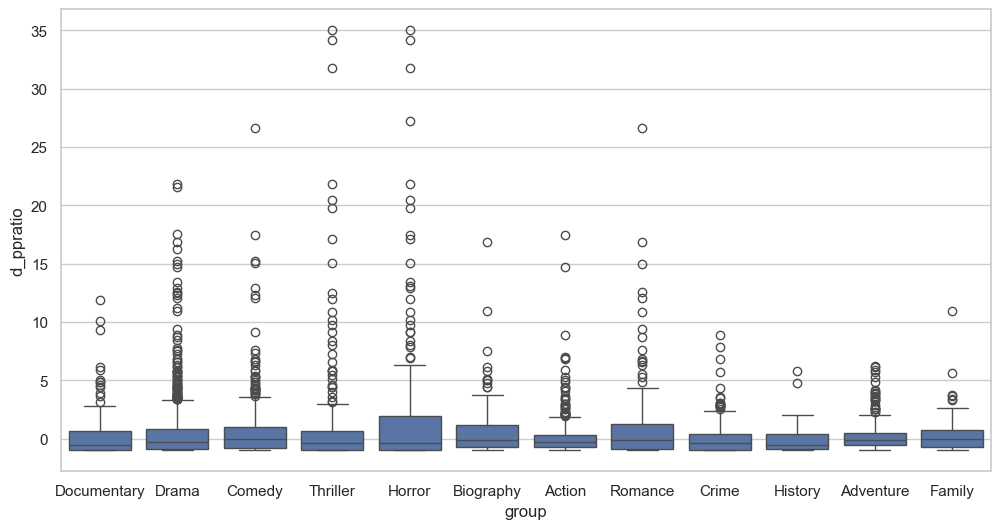

In [212]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='group', y='d_ppratio', data=combined_df);

### Going to leave the outliers like this for now, the data is not normal, it is skewed positive.  Lets look at the risiduals

# Stats models ols code

model = ols('d_ppratio ~ C(group)', data=combined_df).fit()

residuals = model.resid
# Create a Q-Q plot
fig = sm.qqplot(residuals, line='s')  # 's' indicates a standardized line

# Display the plot
plt.show()

### Ouch, very not normal residuals!  Lets try log transformation

# Stats models ols code
combined_df['log_d_ppratio'] = np.log(combined_df['d_ppratio'])
model = ols('log_d_ppratio ~ C(group)', data=combined_df).fit()

residuals = model.resid
# Create a Q-Q plot
fig = sm.qqplot(residuals, line='s')  # 's' indicates a standardized line

# Display the plot
plt.show()

### A little better, how about square root transformation ?

combined_df['sqrt_d_ppratio'] = np.sqrt(combined_df['d_ppratio'])
model = ols('sqrt_d_ppratio ~ C(group)', data=combined_df).fit()

residuals = model.resid
# Create a Q-Q plot
fig = sm.qqplot(residuals, line='s')  # 's' indicates a standardized line

# Display the plot
plt.show()

### Worse than log and there are errors (probably trying to sqrt negative numbers?), how about Box-Cox?

# Fit the model
model = ols('sqrt_d_ppratio ~ C(group)', data=combined_df).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)

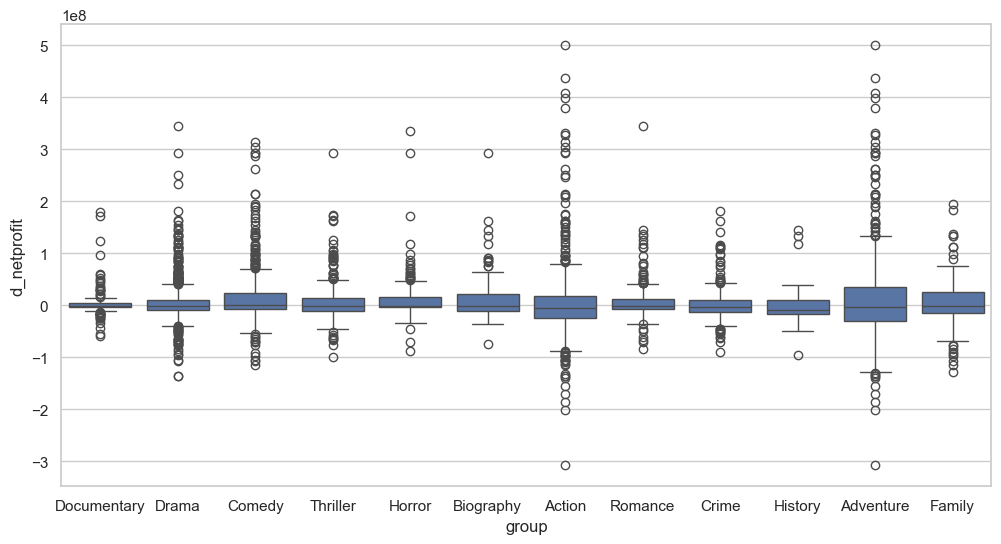

In [213]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='group', y='d_netprofit', data=combined_df);

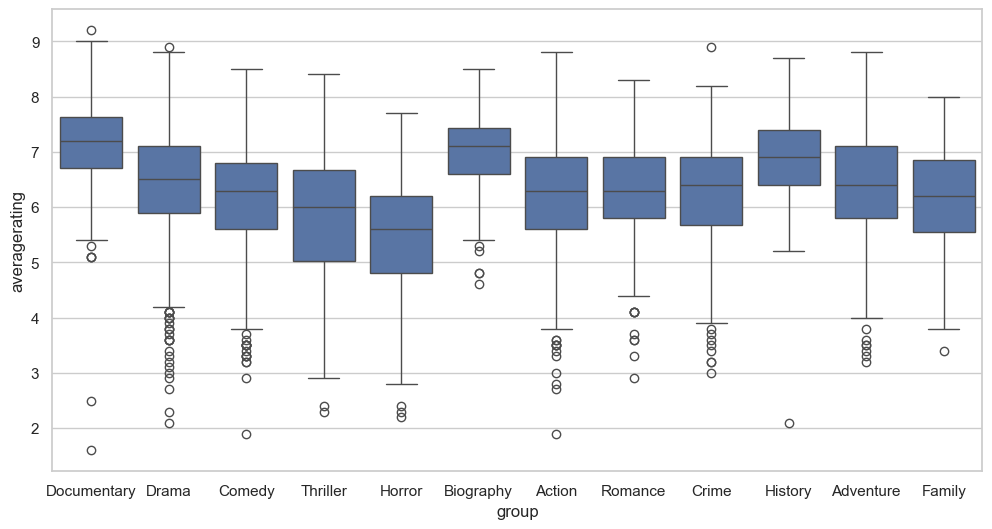

In [214]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='group', y='averagerating', data=combined_df);

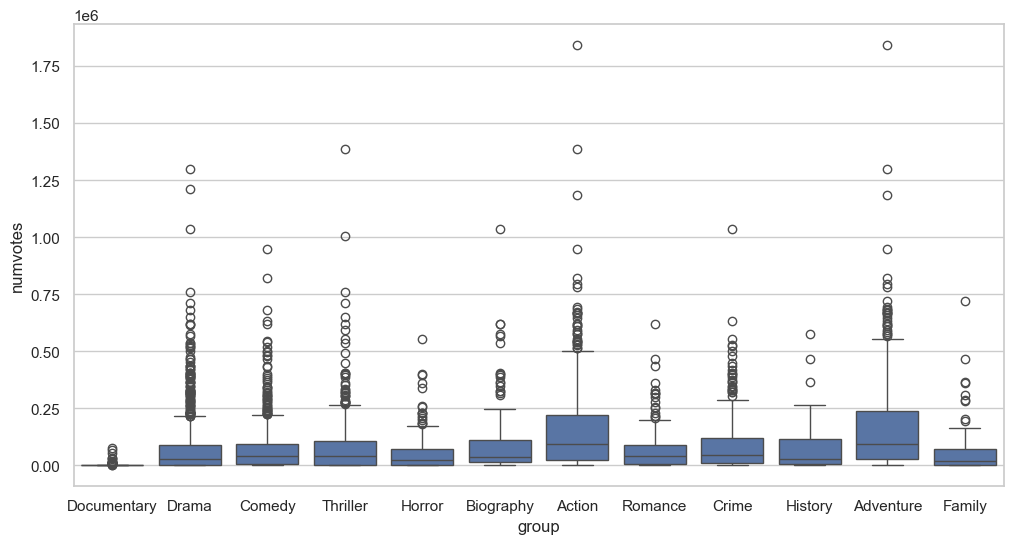

In [215]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='group', y='numvotes', data=combined_df);

### Interesting results, but I'm not crazy about the non-normality of d_ppratio.  Going to see what this looks like using Central Limit Theorum

In [216]:
x = 10000  # the number of samples taken
n = 50   # sample size

#for group in groups:

combined_sample_groups = []
for group in groups:
    # Correctly filter the DataFrame for the current group
    group_data = combined_df[combined_df['group'] == group]['d_ppratio']
    
    # Generate the list of sample means
    sample_means = [np.mean(np.random.choice(group_data, size=n, replace=False)) for _ in range(x)]
    
    # Create a DataFrame from the sample means and assign the current group
    df = pd.DataFrame(sample_means, columns=['d_ppratio_means'])
    df['group'] = group
    
    # Append the DataFrame to the list
    combined_sample_groups.append(df)

# Concatenate all the DataFrames outside the loop
combined_group_means = pd.concat(combined_sample_groups, ignore_index=True)

In [217]:
combined_group_means

,d_ppratio_means,group
0,0.074360,Documentary
1,0.508402,Documentary
2,0.231493,Documentary
3,0.019019,Documentary
4,0.786128,Documentary
...,...,...
119995,0.178717,Family
119996,0.240513,Family
119997,0.197563,Family
119998,0.181814,Family


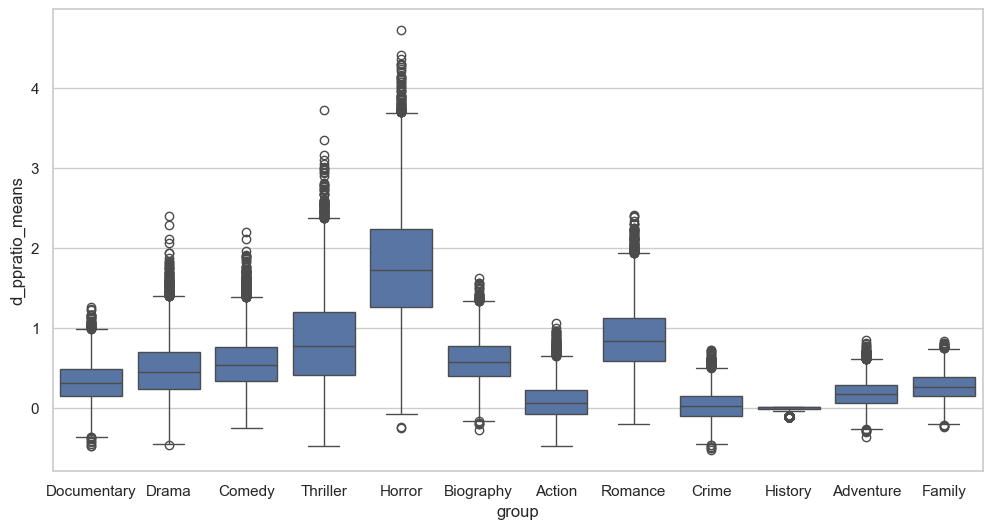

In [218]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='group', y='d_ppratio_means', data=combined_group_means);

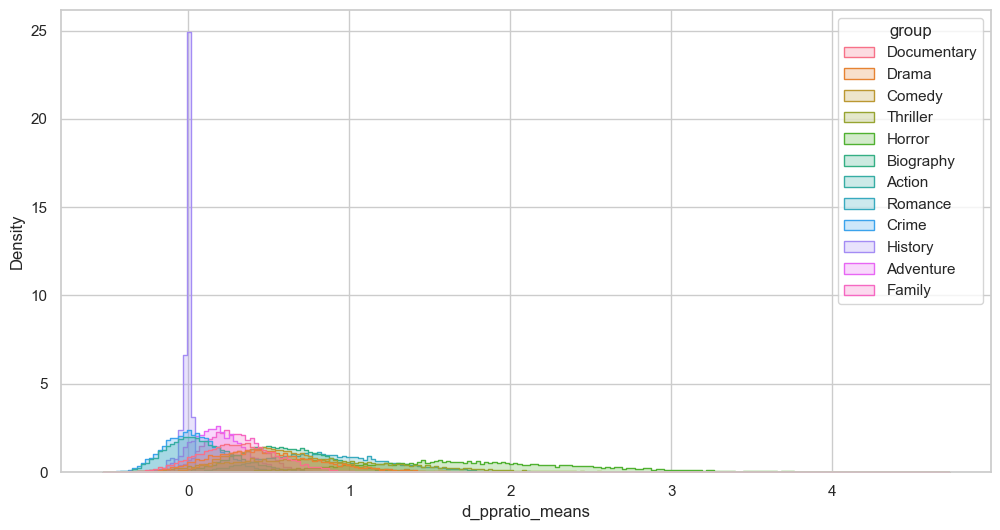

In [219]:
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_group_means, x='d_ppratio_means', hue='group', element='step', stat='density', common_norm=False)

# Display the plot
plt.show()

# Stats Model Code
# Fit the model
model = ols('d_ppratio_means ~ C(group)', data=combined_group_means).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)

In [220]:
combined_group_means.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   d_ppratio_means  120000 non-null  float64
 1   group            120000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


In [221]:
combined_df['year'] = combined_df['year'].astype(int)

# Graphing Top 6 Genres by Profitability Metrics

# Top 6 Genres By DPpratio

# Normalizing the Data - Dividing by Sum
We need to compare these to normalized versions of our means...which will account for difference in sample sizes by genre.

(For reference, here are the sample sizes of each genre...)

In [223]:
combined_df['group'].value_counts()

group
Drama          993
Comedy         613
Action         504
Adventure      389
Thriller       345
Crime          288
Romance        248
Horror         244
Biography      153
Documentary    133
Family         114
History         51
Name: count, dtype: int64

We'll normalize our data by **plotting the means of each d_ppratio per group**

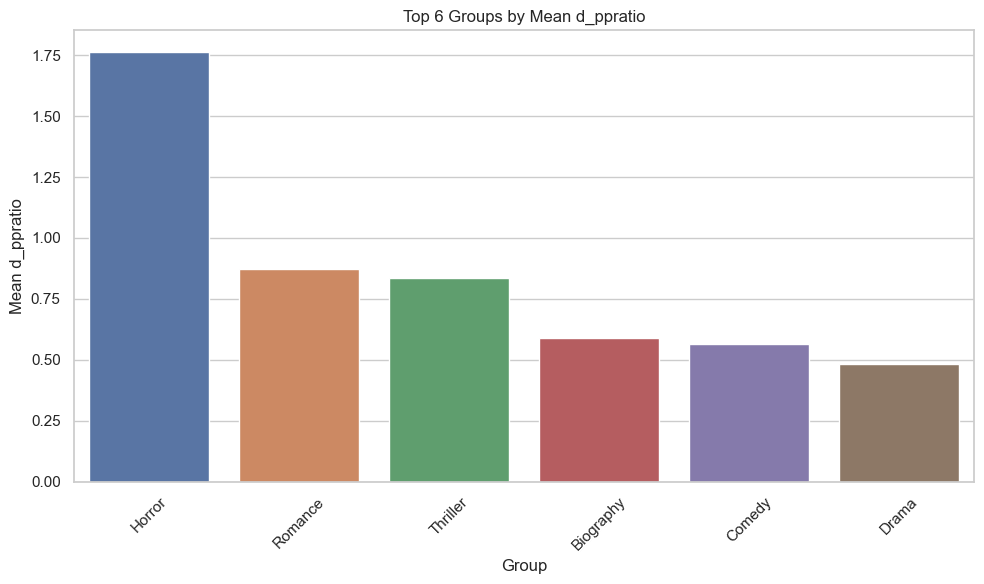

In [224]:
# Calculate mean d_ppratio for each group
mean_d_ppratio = combined_df.groupby('group')['d_ppratio'].mean().reset_index()

# Sort mean_d_ppratio by d_ppratio descending and select top 6 rows
top_6_means = mean_d_ppratio.sort_values(by='d_ppratio', ascending=False).head(6)

# Plotting using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='group', y='d_ppratio', data=top_6_means, hue='group', dodge=False)
plt.title('Top 6 Groups by Mean d_ppratio')
plt.xlabel('Group')
plt.ylabel('Mean d_ppratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculating Risk vs. Reward per Genre...Max & Mins

We can get a good understanding of not only which genre is usually the most profitable...but which genre runs the highest risk of monetary loss as well. A genre might have a really high d_ppratio maximum value (which would indicate a great net profit compared to the budget spent), but might also contain terrifyingly low minimum values (indicating a risk of huge monetary loss).

Let's examine these by plotting *error bars* of the maximum and minimum values per group.

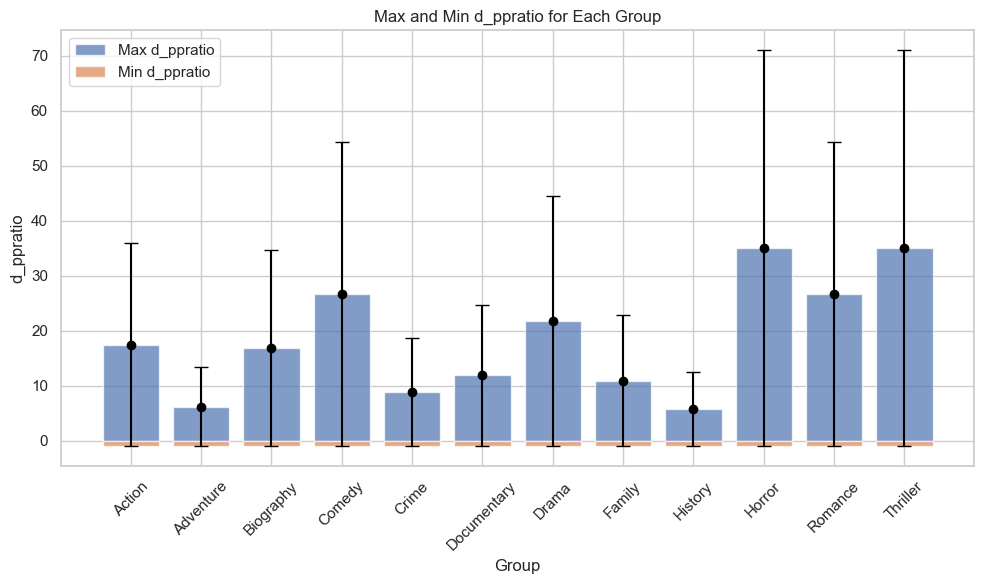

In [227]:
# Calculate max and min d_ppratio for each group
group_stats = combined_df.groupby('group')['d_ppratio'].agg(['max', 'min']).reset_index()

# Plotting with matplotlib
plt.figure(figsize=(10, 6))
plt.bar(group_stats['group'], group_stats['max'], alpha=0.7, label='Max d_ppratio')
plt.bar(group_stats['group'], group_stats['min'], alpha=0.7, label='Min d_ppratio')
plt.errorbar(group_stats['group'], group_stats['max'], yerr=group_stats['max'] - group_stats['min'], fmt='o', color='black', capsize=5)
plt.title('Max and Min d_ppratio for Each Group')
plt.xlabel('Group')
plt.ylabel('d_ppratio')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Plotting range of max-to-min
The graph is slightly hard to interpret. Let's plot the *range* of each groups d_ppratio: groups with greater ranges imply greater risk (though in some cases also greater reward for that risk).

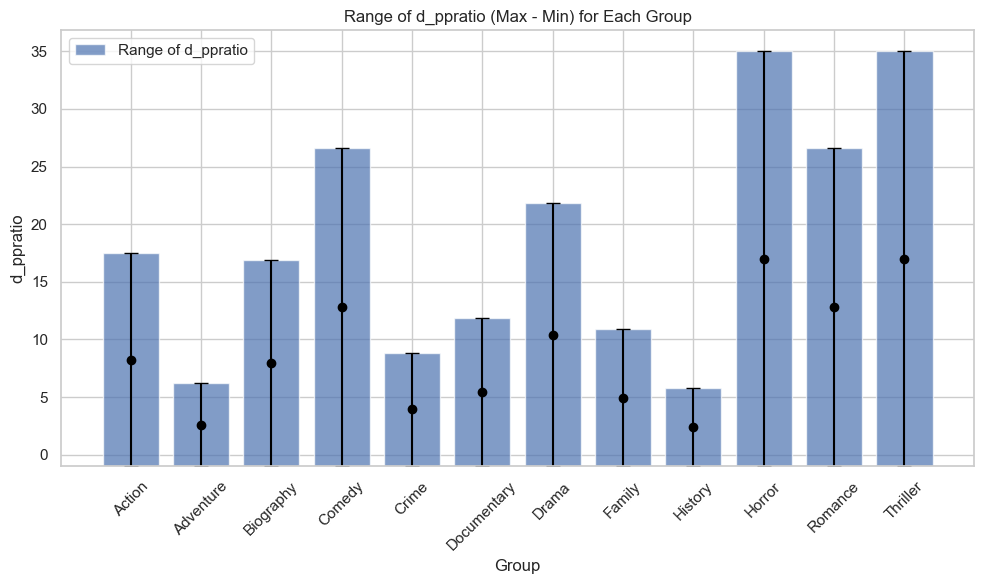

In [228]:
# Calculate max and min d_ppratio for each group
group_stats = combined_df.groupby('group')['d_ppratio'].agg(['max', 'min']).reset_index()

# Plotting with matplotlib
plt.figure(figsize=(10, 6))
plt.bar(group_stats['group'], group_stats['max'] - group_stats['min'], bottom=group_stats['min'], alpha=0.7, label='Range of d_ppratio')
plt.errorbar(group_stats['group'], group_stats['min'] + (group_stats['max'] - group_stats['min']) / 2, yerr=(group_stats['max'] - group_stats['min']) / 2, fmt='o', color='black', capsize=5)
plt.title('Range of d_ppratio (Max - Min) for Each Group')
plt.xlabel('Group')
plt.ylabel('d_ppratio')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Normalizing Range Values to account for differences in sample sizes

Let's divide by the value counts of each group, to see how our range changes when normalized to account for varying sample sizes.

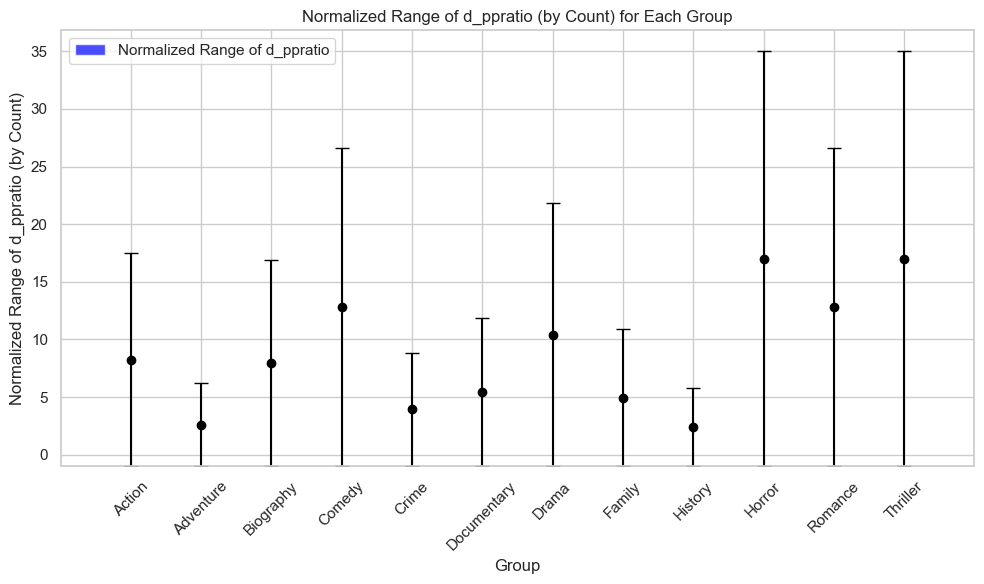

In [230]:
# Calculate max and min d_ppratio for each group
group_stats = combined_df.groupby('group')['d_ppratio'].agg(['max', 'min', 'count']).reset_index()

# Normalize range of d_ppratio values by number of rows (count) for each group
group_stats['normalized_range'] = (group_stats['max'] - group_stats['min']) / group_stats['count']

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))

# Plot bars
plt.bar(group_stats['group'], group_stats['normalized_range'], bottom=group_stats['min'], alpha=0.7, color='blue', label='Normalized Range of d_ppratio')

# Plot error bars
plt.errorbar(group_stats['group'], group_stats['min'] + (group_stats['max'] - group_stats['min']) / 2, yerr=(group_stats['max'] - group_stats['min']) / 2, fmt='o', color='black', capsize=5)

# Plot settings
plt.title('Normalized Range of d_ppratio (by Count) for Each Group')
plt.xlabel('Group')
plt.ylabel('Normalized Range of d_ppratio (by Count)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Assessing Risk - Plotting Minimum Values

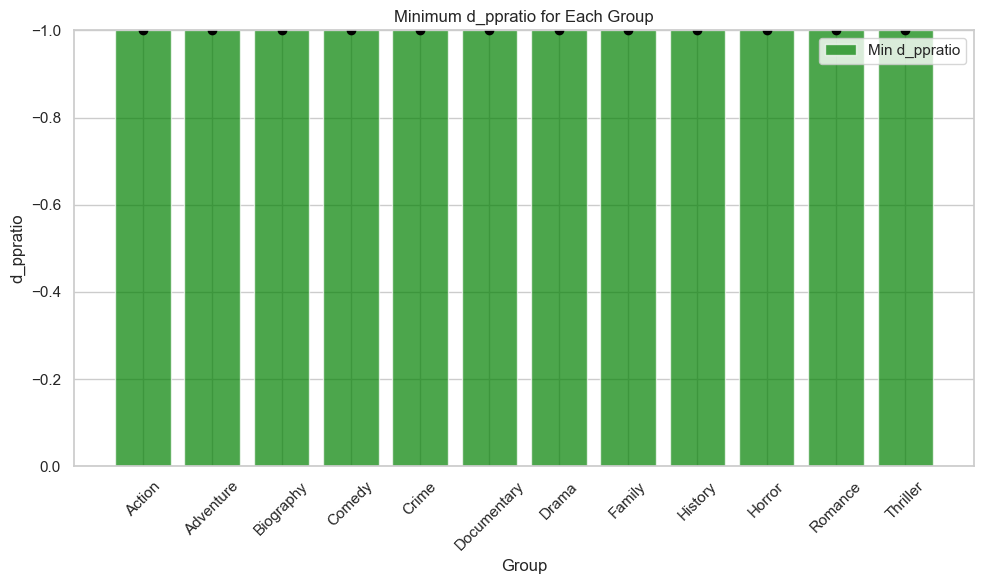

In [235]:
# Calculate min d_ppratio for each group
group_stats = combined_df.groupby('group')['d_ppratio'].min().reset_index()

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))

# Plot bars with positive y-axis for min values
plt.bar(group_stats['group'], group_stats['d_ppratio'], alpha=0.7, color='green', label='Min d_ppratio')

# Error bars (optional)
plt.errorbar(group_stats['group'], group_stats['d_ppratio'], yerr=None, fmt='o', color='black', capsize=5)

# Plot settings
plt.title('Minimum d_ppratio for Each Group')
plt.xlabel('Group')
plt.ylabel('d_ppratio')
plt.xticks(rotation=45)
plt.ylim(0, -1)  # Set y-axis limits to start at 0 and go to -1
plt.legend()
plt.tight_layout()
plt.show()

Not a very helpful graph, let's move on.

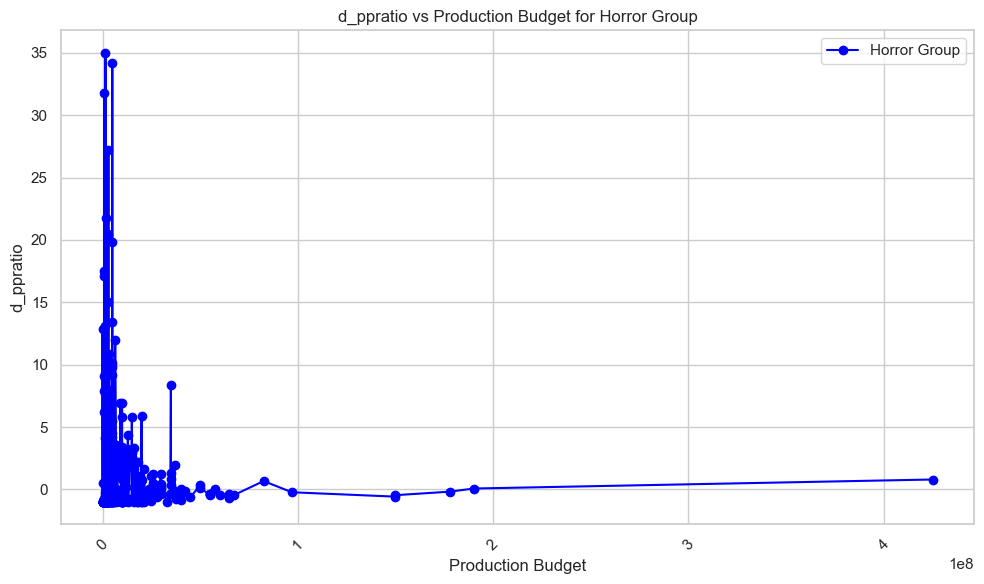

In [237]:
# Filter data for 'Horror' group
horror_data = combined_df[combined_df['group'] == 'Horror']

# Sort by production_budget
horror_data = horror_data.sort_values(by='production_budget')

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(horror_data['production_budget'], horror_data['d_ppratio'], marker='o', linestyle='-', color='blue', label='Horror Group')
plt.title('d_ppratio vs Production Budget for Horror Group')
plt.xlabel('Production Budget')
plt.ylabel('d_ppratio')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Hard to read. Filter to first 100,000 where it looks like most of our data lies.

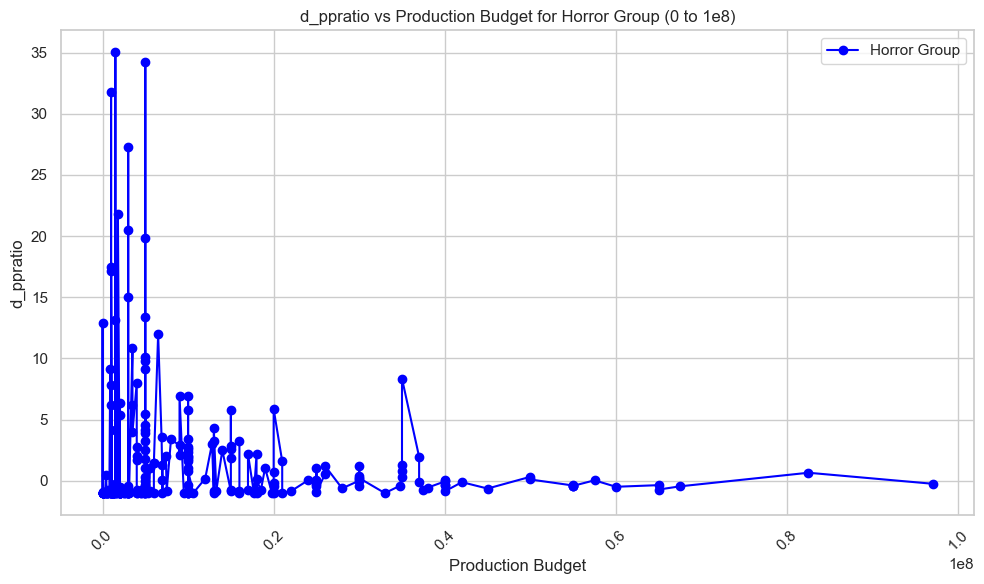

In [238]:
# Filter data for 'Horror' group
horror_data = combined_df[combined_df['group'] == 'Horror']

# Filter production budgets between 0 and 1e8
horror_data = horror_data[(horror_data['production_budget'] >= 0) & (horror_data['production_budget'] <= 1e8)]

# Sort by production_budget
horror_data = horror_data.sort_values(by='production_budget')

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(horror_data['production_budget'], horror_data['d_ppratio'], marker='o', linestyle='-', color='blue', label='Horror Group')
plt.title('d_ppratio vs Production Budget for Horror Group (0 to 1e8)')
plt.xlabel('Production Budget')
plt.ylabel('d_ppratio')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Zoom in further.

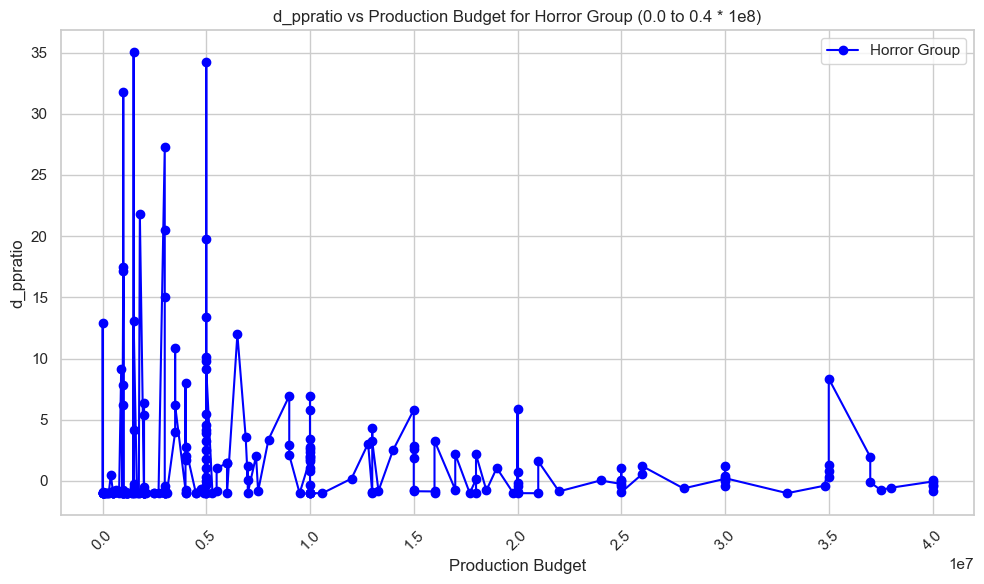

In [239]:
# Filter data for 'Horror' group
horror_data = combined_df[combined_df['group'] == 'Horror']

# Filter production budgets between 0.0 and 0.4 (scaled by 1e8)
horror_data = horror_data[(horror_data['production_budget'] >= 0.0 * 1e8) & (horror_data['production_budget'] <= 0.4 * 1e8)]

# Sort by production_budget
horror_data = horror_data.sort_values(by='production_budget')

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(horror_data['production_budget'], horror_data['d_ppratio'], marker='o', linestyle='-', color='blue', label='Horror Group')
plt.title('d_ppratio vs Production Budget for Horror Group (0.0 to 0.4 * 1e8)')
plt.xlabel('Production Budget')
plt.ylabel('d_ppratio')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

DPpratio compared to AverageRating

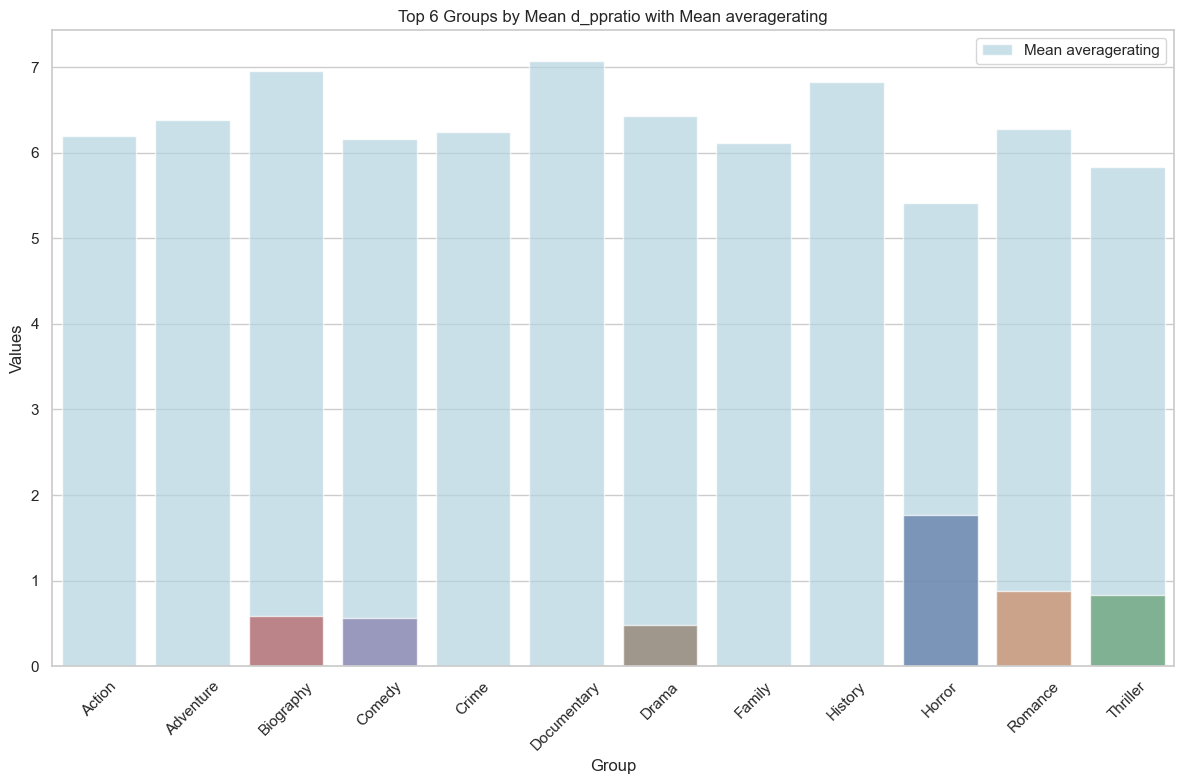

In [242]:
# Calculate mean d_ppratio for each group
mean_d_ppratio = combined_df.groupby('group')['d_ppratio'].mean().reset_index()

# Sort mean_d_ppratio by d_ppratio descending and select top 6 rows
top_6_means = mean_d_ppratio.sort_values(by='d_ppratio', ascending=False).head(6)

# Calculate mean averagerating for each group
mean_averagerating = combined_df.groupby('group')['averagerating'].mean().reset_index()

# Plotting using seaborn
plt.figure(figsize=(12, 8))

# Plot mean averagerating as stacked bars
sns.barplot(x='group', y='averagerating', data=mean_averagerating, alpha=0.7, label='Mean averagerating', color='lightblue')

# Plot d_ppratio for top 6 groups as bars
sns.barplot(x='group', y='d_ppratio', data=top_6_means, alpha=0.7, hue='group', dodge=False)

plt.title('Top 6 Groups by Mean d_ppratio with Mean averagerating')
plt.xlabel('Group')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Too Hard to read. Try the same thing with square roots of avgratings

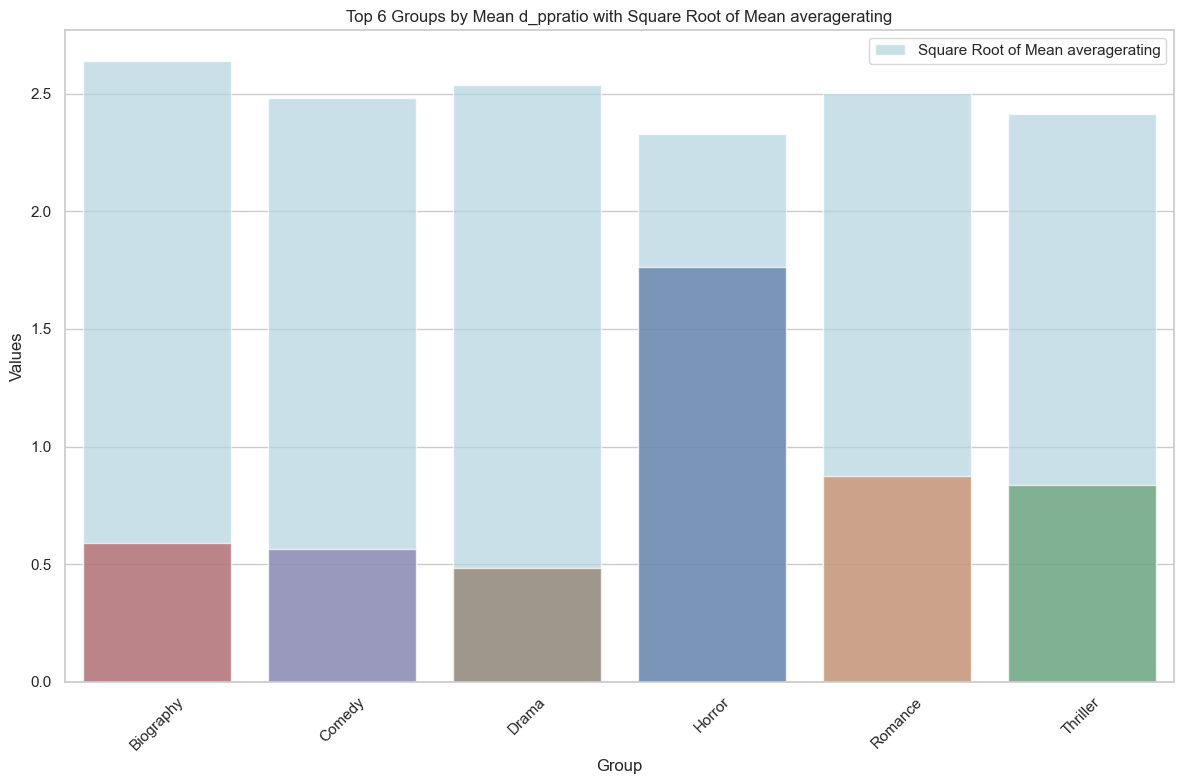

In [244]:
# Calculate mean d_ppratio for each group
mean_d_ppratio = combined_df.groupby('group')['d_ppratio'].mean().reset_index()

# Sort mean d_ppratio by d_ppratio descending and select top 6 rows
top_6_means = mean_d_ppratio.sort_values(by='d_ppratio', ascending=False).head(6)

# Calculate mean averagerating for each group
mean_averagerating = combined_df.groupby('group')['averagerating'].mean().reset_index()

# Square root transformation of averagerating
mean_averagerating['sqrt_averagerating'] = np.sqrt(mean_averagerating['averagerating'])

# Filter mean_averagerating for only the top 6 groups by mean d_ppratio
mean_averagerating = mean_averagerating[mean_averagerating['group'].isin(top_6_means['group'])]

# Plotting using seaborn
plt.figure(figsize=(12, 8))

# Plot square root of mean averagerating as stacked bars
sns.barplot(x='group', y='sqrt_averagerating', data=mean_averagerating, alpha=0.7, label='Square Root of Mean averagerating', color='lightblue')

# Plot d_ppratio for top 6 groups as bars
sns.barplot(x='group', y='d_ppratio', data=top_6_means, alpha=0.7, hue='group', dodge=False)

plt.title('Top 6 Groups by Mean d_ppratio with Square Root of Mean averagerating')
plt.xlabel('Group')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Comparing Ppratios to Net Profits per Genre

We'll have to normalize the net profit means per group, so they fit to the same scale as d_ppratio. We'll divide by the max * 2 for this normalization.

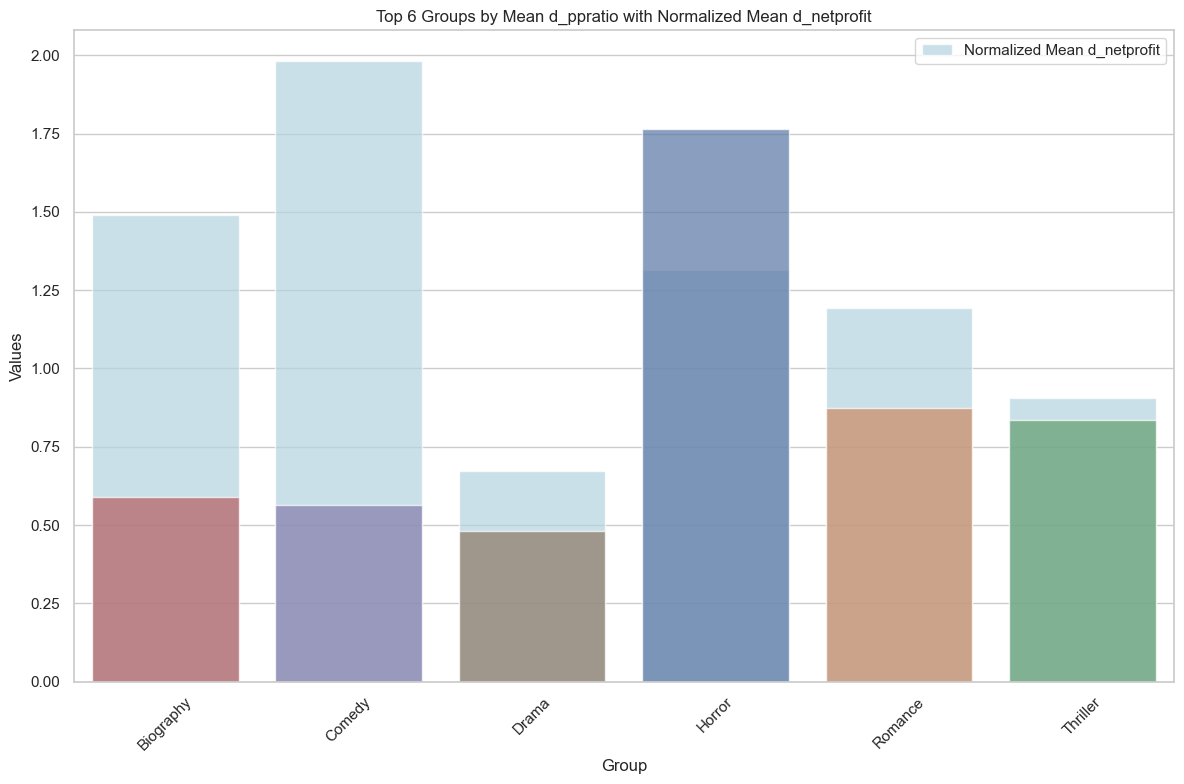

In [247]:
# Calculate mean d_ppratio for each group
mean_d_ppratio = combined_df.groupby('group')['d_ppratio'].mean().reset_index()

# Sort mean d_ppratio by d_ppratio descending and select top 6 rows
top_6_means = mean_d_ppratio.sort_values(by='d_ppratio', ascending=False).head(6)

# Calculate mean d_netprofit for each group
mean_d_netprofit = combined_df.groupby('group')['d_netprofit'].mean().reset_index()

# Normalize d_netprofit to fit on a 0-2 scale
mean_d_netprofit['normalized_d_netprofit'] = mean_d_netprofit['d_netprofit'] / mean_d_netprofit['d_netprofit'].max() * 2

# Filter mean_d_netprofit for only the top 6 groups by mean d_ppratio
mean_d_netprofit = mean_d_netprofit[mean_d_netprofit['group'].isin(top_6_means['group'])]

# Plotting using seaborn
plt.figure(figsize=(12, 8))

# Plot normalized mean d_netprofit as stacked bars
sns.barplot(x='group', y='normalized_d_netprofit', data=mean_d_netprofit, alpha=0.7, label='Normalized Mean d_netprofit', color='lightblue')

# Plot d_ppratio for top 6 groups as bars
sns.barplot(x='group', y='d_ppratio', data=top_6_means, alpha=0.7, hue='group', dodge=False)

plt.title('Top 6 Groups by Mean d_ppratio with Normalized Mean d_netprofit')
plt.xlabel('Group')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Fascinating!!! Looks like horror has the highest d_ppratio, but comedy and biography have the highest net profit!

This tells us that in horror your more likely to make money, but when you *do* make money in comedy or biographies, you're likely to make *more* money!

Let's just graph the net-profits to flesh out this analysis...

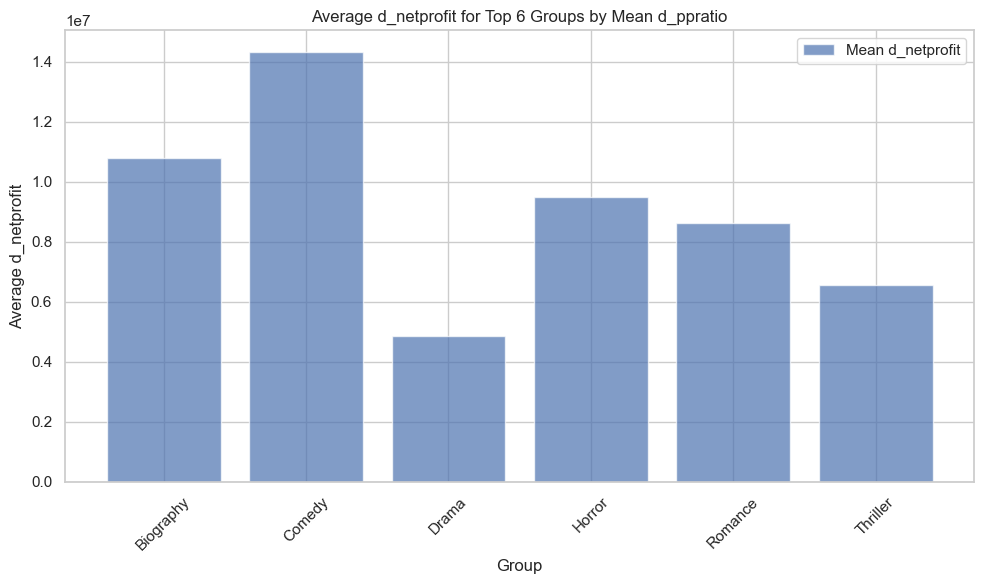

In [248]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame top_6_means with 'group' and 'd_netprofit' columns
# Calculate mean d_netprofit for each group in top_6_means
mean_d_netprofit = combined_df.groupby('group')['d_netprofit'].mean().reset_index()

# Filter mean_d_netprofit for only the groups in top_6_means
mean_d_netprofit_top_6 = mean_d_netprofit[mean_d_netprofit['group'].isin(top_6_means['group'])]

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(mean_d_netprofit_top_6['group'], mean_d_netprofit_top_6['d_netprofit'], alpha=0.7, label='Mean d_netprofit')
plt.title('Average d_netprofit for Top 6 Groups by Mean d_ppratio')
plt.xlabel('Group')
plt.ylabel('Average d_netprofit')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Looks the same. We'll keep this in mind.

# Studios

Studios can have an *enormous* affect on the future of a film. Let's see if there are any overlapping studios for our genres with the top three d_ppratio's.

## Horror Studios

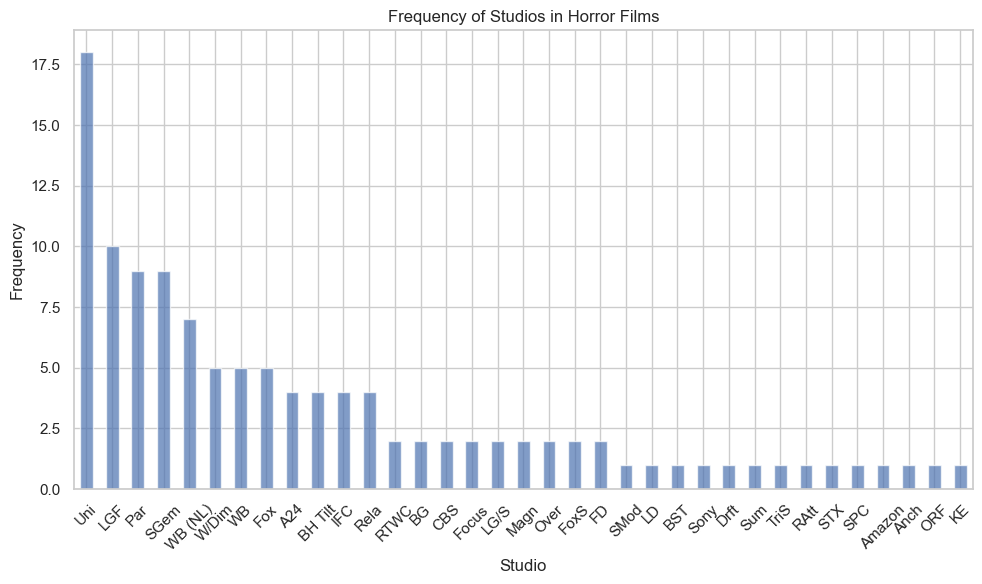

In [251]:
# Filter data where 'group' is 'Horror'
horror_data = combined_df[combined_df['group'] == 'Horror']

# Count frequency of each 'studio' value
studio_counts = horror_data['studio'].value_counts()

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
studio_counts.plot(kind='bar', alpha=0.7)
plt.title('Frequency of Studios in Horror Films')
plt.xlabel('Studio')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Romance Studios

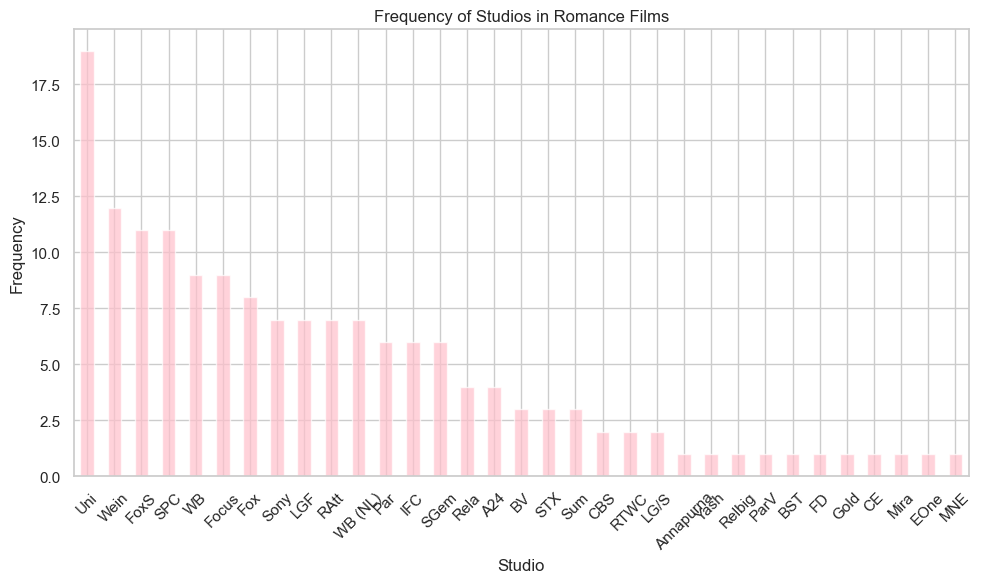

In [252]:
# Filter data where 'group' is 'Romance'
romance_data = combined_df[combined_df['group'] == 'Romance']

# Count frequency of each 'studio' value
studio_counts = romance_data['studio'].value_counts()

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
studio_counts.plot(kind='bar', alpha=0.7, color='pink')  # Customize color if needed
plt.title('Frequency of Studios in Romance Films')
plt.xlabel('Studio')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Thriller Studios

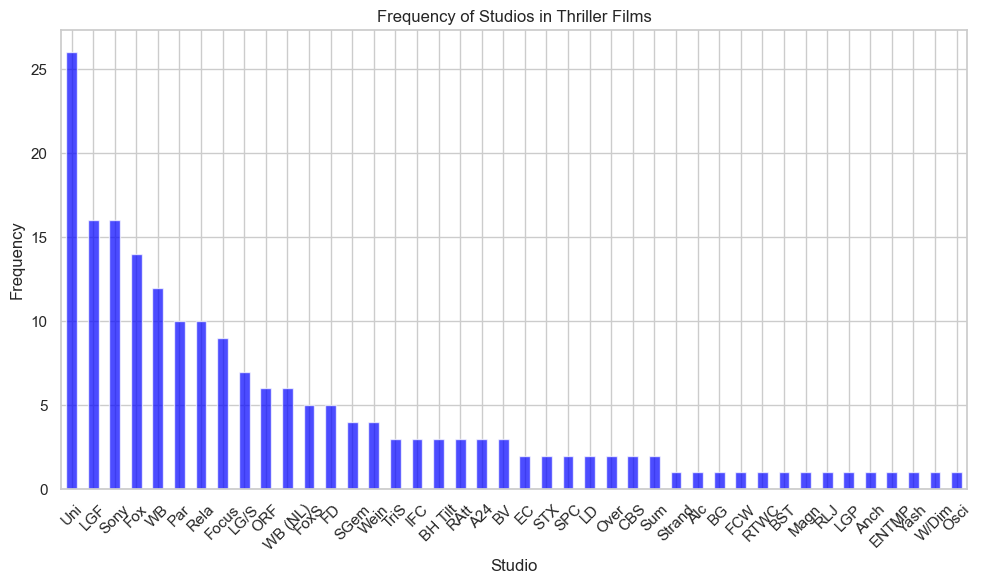

In [253]:
# Filter data where 'group' is 'Thriller'
thriller_data = combined_df[combined_df['group'] == 'Thriller']

# Count frequency of each 'studio' value
studio_counts = thriller_data['studio'].value_counts()

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
studio_counts.plot(kind='bar', alpha=0.7, color='blue')  # Customize color if needed
plt.title('Frequency of Studios in Thriller Films')
plt.xlabel('Studio')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Plotting Top 12 Studios with Highest D_ppratios

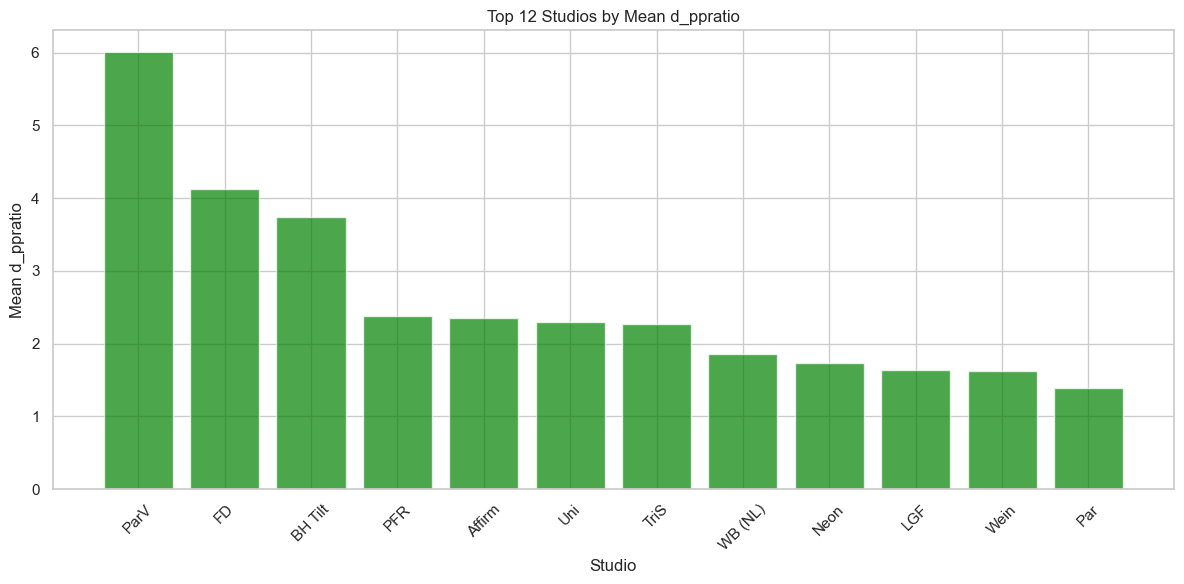

In [254]:
# Calculate mean d_ppratio for each studio
studio_means = combined_df.groupby('studio')['d_ppratio'].mean().reset_index()

# Sort studios by mean d_ppratio descending and select top 12
top_12_studios = studio_means.sort_values(by='d_ppratio', ascending=False).head(12)

# Plotting using Matplotlib
plt.figure(figsize=(12, 6))
plt.bar(top_12_studios['studio'], top_12_studios['d_ppratio'], alpha=0.7, color='green')  # Customize color if needed
plt.title('Top 12 Studios by Mean d_ppratio')
plt.xlabel('Studio')
plt.ylabel('Mean d_ppratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Interesting Findings!

This is super interesting because 'Uni' is the #1 studio used for the horror, thriller, and romance films in our dataset...yet it's 6th place when put into a studio comparison based on d_ppratio average.

This suggests that 'Uni' is used frequently among those genres...but is **not responsible for the films within those genres that return the highest net profits**.

Let's look at our top 5 studios: ParV, FD, BH Tilt, and PFR...and compare them with our top genres.

# NOTE! 'PARV' MIGHT BE THE SAME AS 'PAR'...MIGHT BE A TYPO

# First compare top studios with their normalized net profits

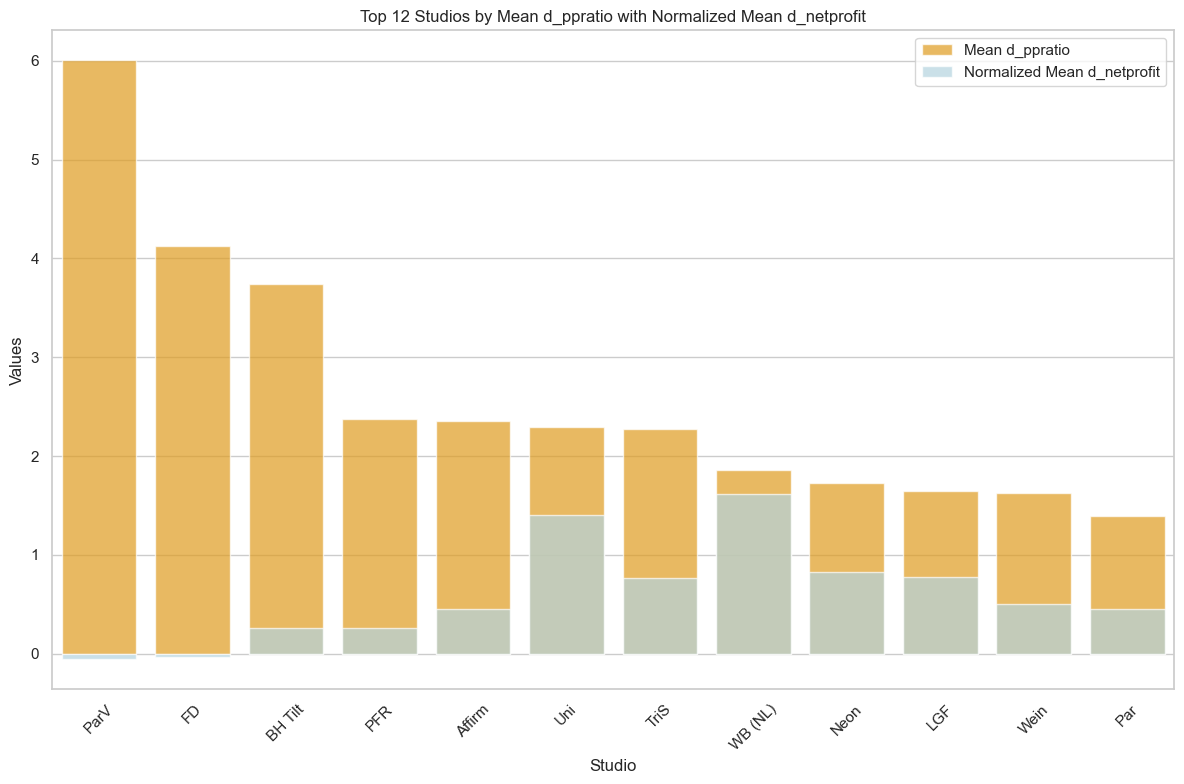

In [263]:
# Calculate mean d_netprofit for each studio
mean_d_netprofit_studio = combined_df.groupby('studio')['d_netprofit'].mean().reset_index()

# Normalize d_netprofit to fit on a 0-2 scale
mean_d_netprofit_studio['normalized_d_netprofit'] = mean_d_netprofit_studio['d_netprofit'] / mean_d_netprofit_studio['d_netprofit'].max() * 2

# Filter mean_d_netprofit for only the top 12 studios by mean d_ppratio
mean_d_netprofit_studio = mean_d_netprofit_studio[mean_d_netprofit_studio['studio'].isin(top_12_studios['studio'])]

# Plotting using seaborn
plt.figure(figsize=(12, 8))

# Plot d_ppratio for top 12 studios as bars
sns.barplot(x='studio', y='d_ppratio', data=top_12_studios, alpha=0.7, label='Mean d_ppratio', color='orange')

# Plot normalized mean d_netprofit as stacked bars in front
sns.barplot(x='studio', y='normalized_d_netprofit', data=mean_d_netprofit_studio, alpha=0.7, label='Normalized Mean d_netprofit', color='lightblue')

plt.title('Top 12 Studios by Mean d_ppratio with Normalized Mean d_netprofit')
plt.xlabel('Studio')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Super super interesting...once again highest 'net profit' is not synonymous with highest ppratio.

Furthermore, the studios associated with higher net-profits in the graph above, are some of the top studios from our 'top studios by genre' graphs above - such as Uni, wein, LFG, WB(NL)...yet none are in the top 5 ddpratio.